# 0.0 Imports

## 0.1. Imports

In [1]:
import pandas            as pd
import numpy             as np
import postgresql.driver as pg_driver
import seaborn           as sns
import random            as rd
import xgboost           as xgb
import scikitplot        as skplt
   
from matplotlib           import pyplot          as plt
from sklearn              import model_selection as ms 
from sklearn              import metrics         as m
from scikitplot           import metrics         as mt
from imblearn             import combine         as c
from imblearn             import over_sampling   as oversamp
from sklearn              import preprocessing   as pp
from scipy                import stats           as ss

from category_encoders    import OneHotEncoder
from IPython.core.display import HTML
from IPython.core.display import Image
from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta               import BorutaPy
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from lightgbm             import LGBMClassifier
from pandas_profiling     import ProfileReport

import os
import json
import kaggle
import pickle
import warnings
warnings.filterwarnings("ignore")

## 0.2. Helper Functions

### Models

In [2]:
def models_train(models,x_train,y_train,x_test,y_test,predict='predict',metric='regression',verbose=1):
    metrics=pd.DataFrame()
    for model in models:
        print(model.__class__.__name__)
        model.fit(x_train,y_train)
        if predict=='predict':
            yhat=model.predict(x_test)
        elif predict=='predict_proba':
            yhat=model.predict_proba(x_test)
            yhat=yhat[:, 1]
        
        if metric=='regression':
            metrics=metrics.append(regression_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='multiClass':
            metrics=metrics.append(multi_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='binaryClass':
            metrics=metrics.append(ranking_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
            
    return metrics

### Graphics

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v    

In [6]:
def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

### Metricals

In [7]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [8]:
def regression_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T
    
    metrics = pd.concat([model,accdf,balanceddf,kappadf]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [9]:
def multi_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T
    
    #MAtthews Correlation
    mcc=m.matthews_corrcoef(y_val,yhat)
    mccdf=pd.DataFrame([mcc])    
    
    metrics = pd.concat([model,precisiondf,recalldf,f1df,mccdf]).T.reset_index()
    metrics.columns=['Index','Model','Precision Score','Recall Score','F1 Score','Matthew Correlation Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Precision Score: {}'.format(precision))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        print('Matthew Correlation Score: {}'.format(mcc))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [10]:
def ranking_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #AUC_ROC
    roc=m.roc_auc_score(y_val,yhat)
    rocdf=pd.DataFrame([roc])
    
    #topk Score
    knum=y_val.value_counts().count()-1
    topk=m.top_k_accuracy_score(y_val,yhat,k=knum)
    topkdf=pd.DataFrame([topk])    
    
    metrics = pd.concat([model,rocdf,topkdf]).T.reset_index()
    metrics.columns=['Index','Model','ROC AUC','Top K Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [11]:
def precision_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df[target].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

In [12]:
def recall_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df[target].cumsum()/df[target].sum()
    return df.loc[k,'recall_at_k']

In [13]:
def topK_performance(df,probas,response,perc):
    df_final_performance=pd.DataFrame()
    for i in probas:   
        for j in perc:
            k=int(np.floor(len(df_mp)*j))

            df_tg=df.copy()
            target_total=df_tg[response].sum()
            df_tg['score']= i[:,1].tolist()
            df_tg=df_tg.sort_values('score',ascending=False)
            target_at_k=df_tg[response][:k].sum()
            target_perc=target_at_k/target_total

            precision=precision_at_k(df,i,response,j)
            recall=recall_at_k(df,i,response,j)

            df_final_performance=df_final_performance.append({'Model':'Model','perc':j,'k':k,'precision':precision,'recall':recall,'target_total':target_total,'target_at_k':target_at_k,'perc_target':target_perc},ignore_index=True)
    return df_final_performance

### Database

In [14]:
def pg_connect():
    
    credentialsFile=open('../db/credentials.json')
    credentials=json.load(credentialsFile)

    db = pg_driver.connect(user = credentials['user'],
                           password = credentials['password'],
                           host = credentials['host'],
                           port = credentials['port'],
                           database=credentials['database'])
    credentialsFile.close()
    return db

In [15]:
def pg_query(sql):

    db = pg_connect()
    query = db.prepare(sql)
    result = query()
    db.close()
    return result

### Supress Notation

In [16]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### CrossValidation

In [17]:
def cross_validation(num_folds,modelName,model,x,y,metric):
    kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=seed)

    cv_rf_metrics_list=pd.DataFrame()

    i=1

    for train_cv,val_cv in kfold.split(x_train,y_train):
        print('Fold Number {}/{}'.format(i,num_folds))

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model=model_fit.predict(x_val_fold)
        #metrics = model_metrics(modelName,y_val_fold,yhat_model,0)
        cv_rf_metrics_list = cv_rf_metrics_list.append(metric('{} - {}/{}'.format(modelName,i,num_folds),y_val_fold,yhat_model,0))

        i+=1
    return cv_rf_metrics_list

### Enconding

In [18]:
def frequency_enconding(df,column):
    enconding=(df.groupby(column).size())/len(df)
    return enconding

## 0.3. Data Summary

**Id**:Unique ID for the customer

**Gender**: Gender of the customer

**Age**: Age of the customer

**Driving License**: 0 : Customer does not have DL, 1 : Customer already has DL

**Region Code**: 	Unique code for the region of the customer

**Previously Insured**: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

**Vehicle Age**: Age of the Vehicle

**Vehicle Damage**: 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Anual Premium**: 	The amount customer needs to pay as premium in the year

**Policy sales channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage**: Number of Days, Customer has been associated with the company

**Response**: 1 : Customer is interested, 0 : Customer is not interested

## 0.4. Data Load

In [19]:
sqlFile=open('../db/loadFullData.sql')
sql=sqlFile.read()

In [20]:
result = pg_query(sql)
sqlFile.close()

In [21]:
df_raw=pd.DataFrame(result)
df_raw.columns=['id','previouslyInsured','annualPremium','vintage','response','gender','age','regionCode',
               'policySalesChannel','drivingLicense','vehicleAge','vehicleDamage']

In [19]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  381109 non-null  int64  
 1   previouslyInsured   381109 non-null  int64  
 2   annualPremium       381109 non-null  float64
 3   vintage             381109 non-null  int64  
 4   response            381109 non-null  int64  
 5   gender              381109 non-null  object 
 6   age                 381109 non-null  int64  
 7   regionCode          381109 non-null  float64
 8   policySalesChannel  381109 non-null  float64
 9   drivingLicense      381109 non-null  int64  
 10  vehicleAge          381109 non-null  object 
 11  vehicleDamage       381109 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
!kaggle datasets list -s anmolkumar/health-insurance-cross-sell-prediction

In [ ]:
!kaggle datasets files -v anmolkumar/health-insurance-cross-sell-prediction

In [ ]:
!kaggle datasets download anmolkumar/health-insurance-cross-sell-prediction -f test.csv -p ../dataset/ --unzip

In [74]:
df_test=pd.read_csv('../dataset/test.csv')
df_test.columns=['id','gender','age','drivingLicense','regionCode','previouslyInsured','vehicleAge','vehicleDamage','annualPremium','policySalesChannel','vintage']

In [ ]:
df_test.info()

In [22]:
seed=77

# 1.0. Data Description

In [23]:
df_dd=df_raw.copy()

In [22]:
df_dd.sample(10)

id  previouslyInsured  annualPremium  vintage  response  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage
375119  333309                  1     44687.0000      150         0    Male   43     15.0000             14.0000               1   1-2 Year            No
55630    62925                  1     23001.0000      102         0  Female   22     15.0000            152.0000               1   < 1 Year            No
46662   372064                  1     37746.0000      233         0    Male   36     28.0000            124.0000               1   1-2 Year            No
162145  151724                  0     39396.0000       40         0    Male   48     30.0000            124.0000               1   1-2 Year           Yes
86570   309499                  1     22116.0000      185         0    Male   63      6.0000            124.0000               1   1-2 Year            No
90889   343983                  0     41267.0000      215         1  Female   47      8.0000            157.0000               1   1-2 Year           Yes
241694   25822                  0     35926.0000      295         1    Male   55     29.0000             26.0000               1   < 1 Year           Yes
286368    1048                  0     35427.0000      237         1  Female   50     11.0000            124.0000               1   1-2 Year           Yes
114175  149492                  1     37160.0000       86         0  Female   77     50.0000            124.0000               1   1-2 Year            No
365774  258923                  0     32412.0000      164         0    Male   47     34.0000             26.0000               1   1-2 Year           Yes

## <s>1.1. Rename Column<s>

## 1.2. Data Dimension

In [22]:
print('Total Rows: {}'.format(df_dd.shape[0]))
print('Total Columns: {}'.format(df_dd.shape[1]))

Total Rows: 381109
Total Columns: 14


## 1.3. Data Types

In [23]:
df_dd.dtypes

idInsurance             int64
previouslyInsured       int64
annualPremium         float64
vintage                 int64
response                int64
idUser                  int64
gender                 object
age                     int64
regionCode            float64
policySalesChannel    float64
idVehicle               int64
drivingLicense          int64
vehicleAge             object
vehicleDamage          object
dtype: object

## 1.4. Check NA

In [24]:
df_dd.isna().sum()

idInsurance           0
previouslyInsured     0
annualPremium         0
vintage               0
response              0
idUser                0
gender                0
age                   0
regionCode            0
policySalesChannel    0
idVehicle             0
drivingLicense        0
vehicleAge            0
vehicleDamage         0
dtype: int64

## <s>1.5. Fill NA</s>
No one NA was detected

## 1.6. Check Balance Data

In [25]:
df_dd['response'].value_counts(normalize=True)

0   0.8774
1   0.1226
Name: response, dtype: float64

About 12,26% of all customers have interest on vehicle insurance

## 1.7. Statistical Description

In [21]:
numerical_columns=df_dd.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_columns=df_dd.select_dtypes(exclude=['int64','float64']).columns.tolist()

### 1.7.1. Numerical Attributes

In [26]:
na_resume=numerical_metrics(df_dd[numerical_columns])
na_resume

Attributes       Min         Max       Range        Mean      Median         STD     Skew  Kurtosis
0          idInsurance    1.0000 381109.0000 381108.0000 190555.0000 190555.0000 110016.6919  -0.0000   -1.2000
1    previouslyInsured    0.0000      1.0000      1.0000      0.4582      0.0000      0.4983   0.1677   -1.9719
2        annualPremium 2630.0000 540165.0000 537535.0000  30564.3896  31669.0000  17213.1325   1.7661   34.0046
3              vintage   10.0000    299.0000    289.0000    154.3474    154.0000     83.6712   0.0030   -1.2007
4             response    0.0000      1.0000      1.0000      0.1226      0.0000      0.3279   2.3019    3.2988
5               idUser    1.0000 381109.0000 381108.0000 190555.0000 190555.0000 110016.6919  -0.0000   -1.2000
6                  age   20.0000     85.0000     65.0000     38.8226     36.0000     15.5116   0.6725   -0.5657
7           regionCode    0.0000     52.0000     52.0000     26.3888     28.0000     13.2299  -0.1153   -0.8679
8   policySalesChannel    1.0000    163.0000    162.0000    112.0343    133.0000     54.2039  -0.9000   -0.9708
9            idVehicle    1.0000 381109.0000 381108.0000 190555.0000 190555.0000 110016.6919  -0.0000   -1.2000
10      drivingLicense    0.0000      1.0000      1.0000      0.9979      1.0000      0.0461 -21.5952  464.3543

In [27]:
df_dd[numerical_columns].describe()

idInsurance  previouslyInsured  annualPremium     vintage    response      idUser         age  regionCode  policySalesChannel   idVehicle  drivingLicense
count  381109.0000        381109.0000    381109.0000 381109.0000 381109.0000 381109.0000 381109.0000 381109.0000         381109.0000 381109.0000     381109.0000
mean   190555.0000             0.4582     30564.3896    154.3474      0.1226 190555.0000     38.8226     26.3888            112.0343 190555.0000          0.9979
std    110016.8362             0.4983     17213.1551     83.6713      0.3279 110016.8362     15.5116     13.2299             54.2040 110016.8362          0.0461
min         1.0000             0.0000      2630.0000     10.0000      0.0000      1.0000     20.0000      0.0000              1.0000      1.0000          0.0000
25%     95278.0000             0.0000     24405.0000     82.0000      0.0000  95278.0000     25.0000     15.0000             29.0000  95278.0000          1.0000
50%    190555.0000             0.0000     31669.0000    154.0000      0.0000 190555.0000     36.0000     28.0000            133.0000 190555.0000          1.0000
75%    285832.0000             1.0000     39400.0000    227.0000      0.0000 285832.0000     49.0000     35.0000            152.0000 285832.0000          1.0000
max    381109.0000             1.0000    540165.0000    299.0000      1.0000 381109.0000     85.0000     52.0000            163.0000 381109.0000          1.0000

Most 50% of customer don't have vehicles insurance

Mean value of Health Insurance is about 30k

All customers have less 1 year on Insurance All, being 75% had 227 days

Most 75% of customers don't have interest to buy a vehicle insurance

Most customer are between 25 and 49 years old

Most 75% of customer have driver license

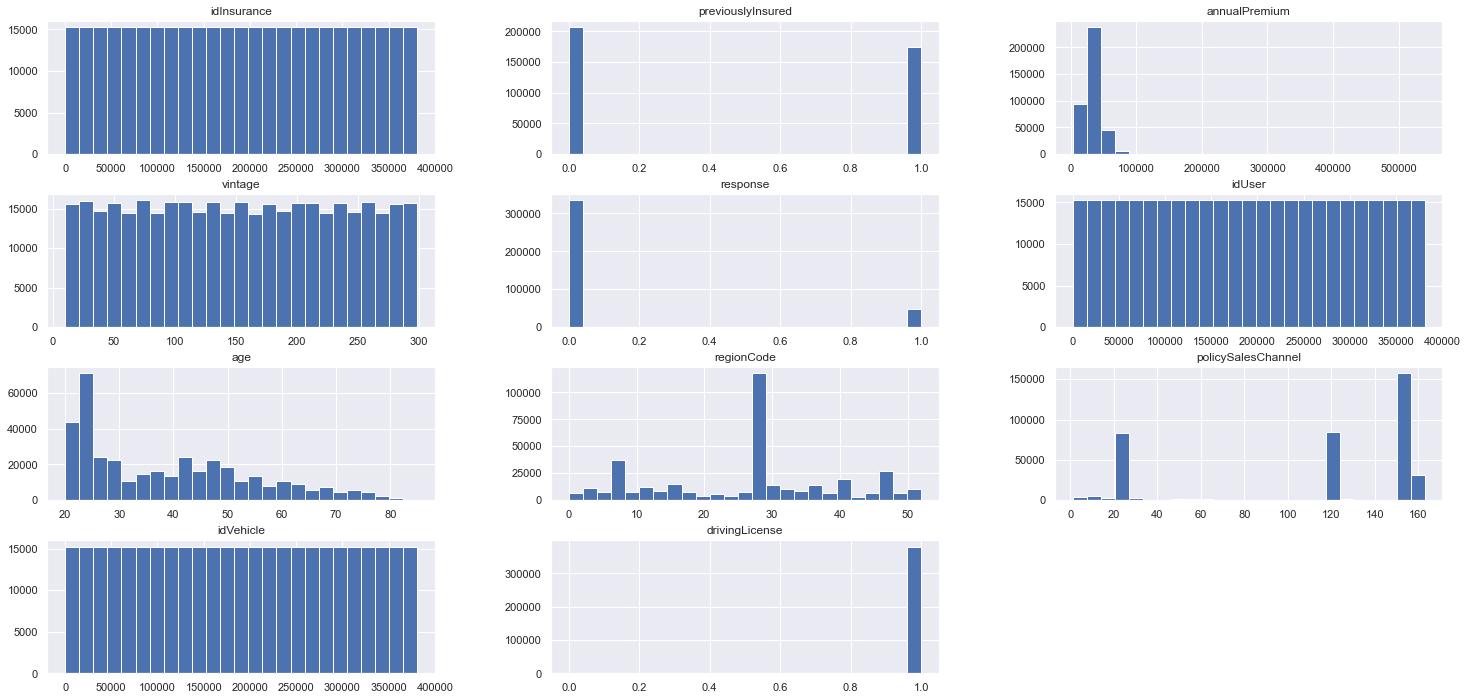

In [28]:
df_dd[numerical_columns].hist(bins=25);

In [20]:
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=seed)
for train_index, test_index in split.split(df_dd,df_dd['response']):
    df_aux = df_dd.loc[test_index]


In [30]:
df_aux['response'].value_counts(normalize=True)

0   0.8775
1   0.1225
Name: response, dtype: float64

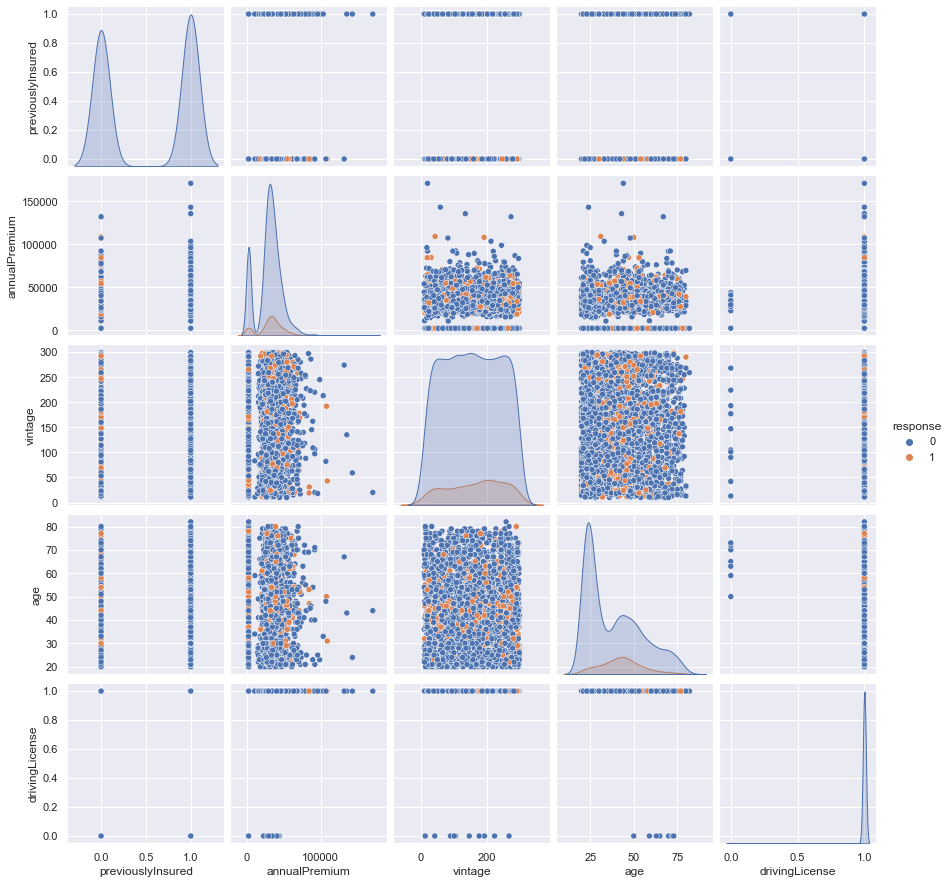

In [31]:
sns.pairplot(df_aux,vars=['previouslyInsured', 'annualPremium', 'vintage', 'age', 'drivingLicense'],hue='response');

### 1.7.2 Categorical Attributes

In [32]:
df_dd[categorical_columns].describe()

gender vehicleAge vehicleDamage
count   381109     381109        381109
unique       2          3             2
top       Male   1-2 Year           Yes
freq    206089     200316        192413

Most customer are Male

53 different regions

155 Policy Sales Channel

Most customers vehicles age is less 2 years

About 54% of customer has vehicles damage on past

In [33]:
df_dd[categorical_columns].apply(lambda x: x.unique().shape[0])

gender           2
vehicleAge       3
vehicleDamage    2
dtype: int64

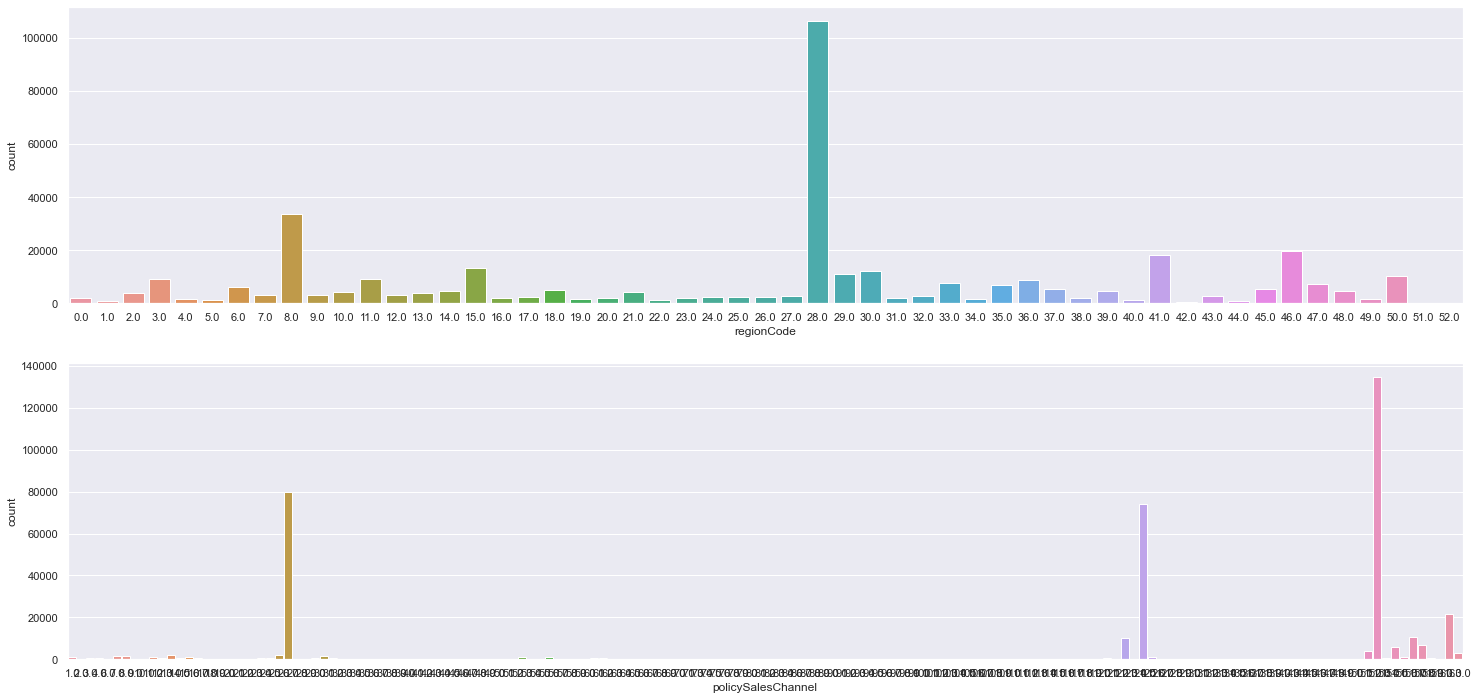

In [34]:
plt.subplot(2,1,1)
sns.countplot(df_dd['regionCode']);

plt.subplot(2,1,2)
sns.countplot(df_dd['policySalesChannel']);

In [36]:
proof = ProfileReport(df_dd)
proof.to_file('../util/profileReport.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2.0. Feature Engieneering

In [24]:
# Spliting test dataset before 
x=df_dd.drop(columns='response')
y=df_dd['response']
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, test_index in split.split(x,y):
    x_train,x_test = x.loc[train_index],x.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
for train_index, test_index in split.split(x_train,y_train):
    x_train,x_val = x_train.iloc[train_index],x.loc[test_index]
    y_train,y_val = y_train.iloc[train_index],y.loc[test_index]

In [25]:
df_fe=pd.concat([x_train,y_train],axis=1)

## 2.1. Business Search

**Features Relevant to Business Model**

Age

Years from driver license

Garage 

Security alarm

Historical Car's Damages, accidents and theft

Gender

Civil State

Car Model

City Risk

sources

https://blog.rodobens.com.br/perfil-no-seguro-auto



**Cross Selling Strategy**

Analyse products interesting to a customer

Dont try cross sell products more expensive then main



Sources:

https://resultadosdigitais.com.br/blog/cross-selling-up-selling/#:~:text=O%20cross%20selling%2C%20também%20chamado,oferta%20que%20o%20cliente%20adquiriu.

https://neilpatel.com/br/blog/cross-selling/


## 2.2. Hypotheses Map

**H1** - Women buy more vehicles insurance than men

**H2** - Customer with cars younger than 2 years old, have more interest on vehicle insurance

**H3** - Customer without driving license don't have interest in vehicles insurance

**H4** - Customers had damage Historical have more interest on vehicle insurance

**H5** - Customer older than 30 years old have more interest in vehicles insurance

**H6** - Customer that paid between 24405 a 39400 on Annual Premium have more interest in vehicles insurance

## 2.3. Feature Engieneering

In [26]:
def feature_Engieneering(df_fe):
    df_fe['riskAge']=df_fe['age'].apply(lambda x: 0 if x>25 else 1)    
    return  df_fe

In [27]:
df_fe=feature_Engieneering(df_fe)

In [28]:
numerical_columns=df_fe.select_dtypes(include=['int64','float64']).columns.tolist()

# 3.0. <s>Balance Data</s>

# 4.0. Exploratory Data Analysis

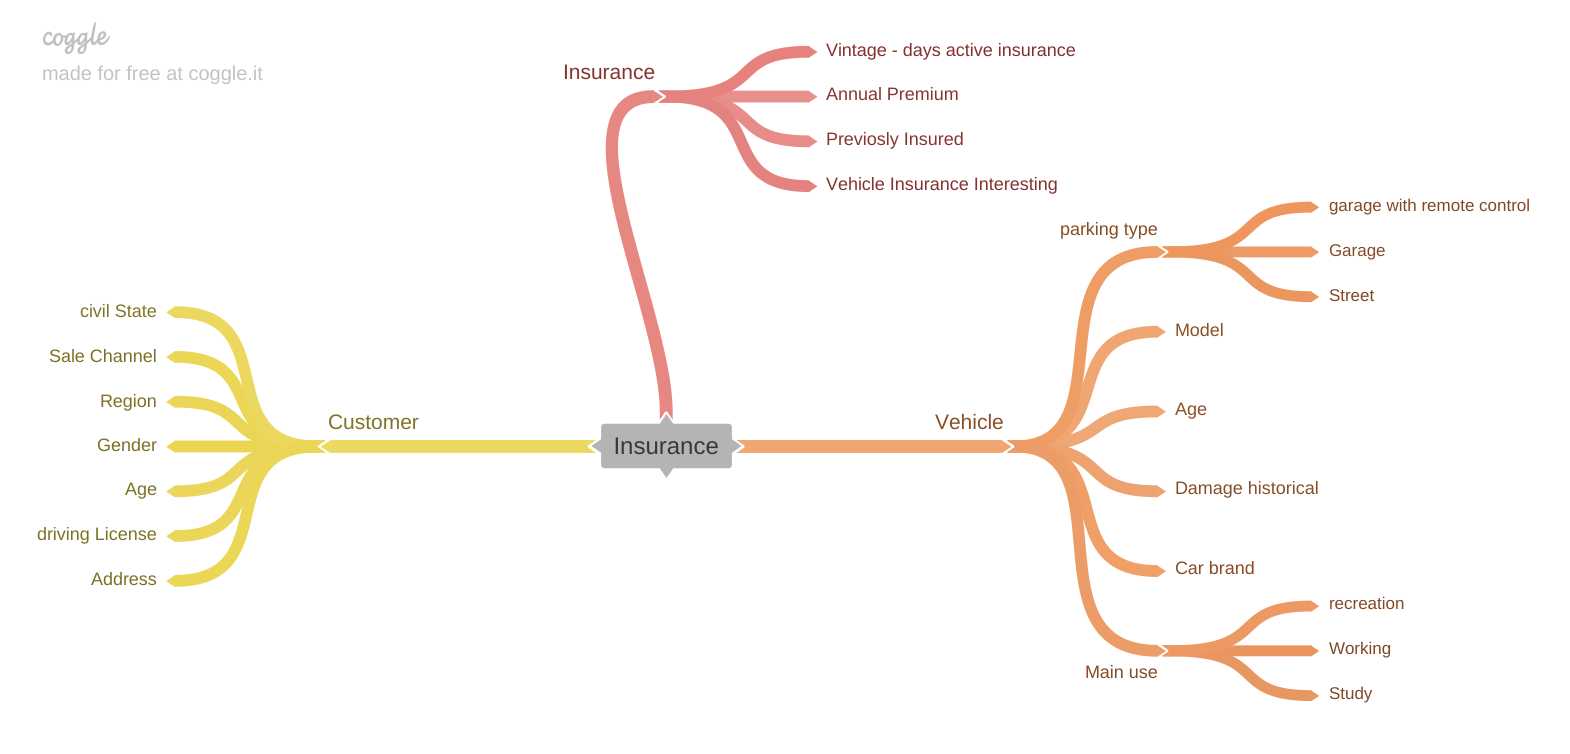

In [29]:
Image('../images/featuresMap.png')

In [45]:
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=77)
for train_index, test_index in split.split(df_fe,df_fe['response']):
    df_eda = df_fe.iloc[train_index]

## 4.1. Univariate Analysis

### 4.1.1. - Target Variable

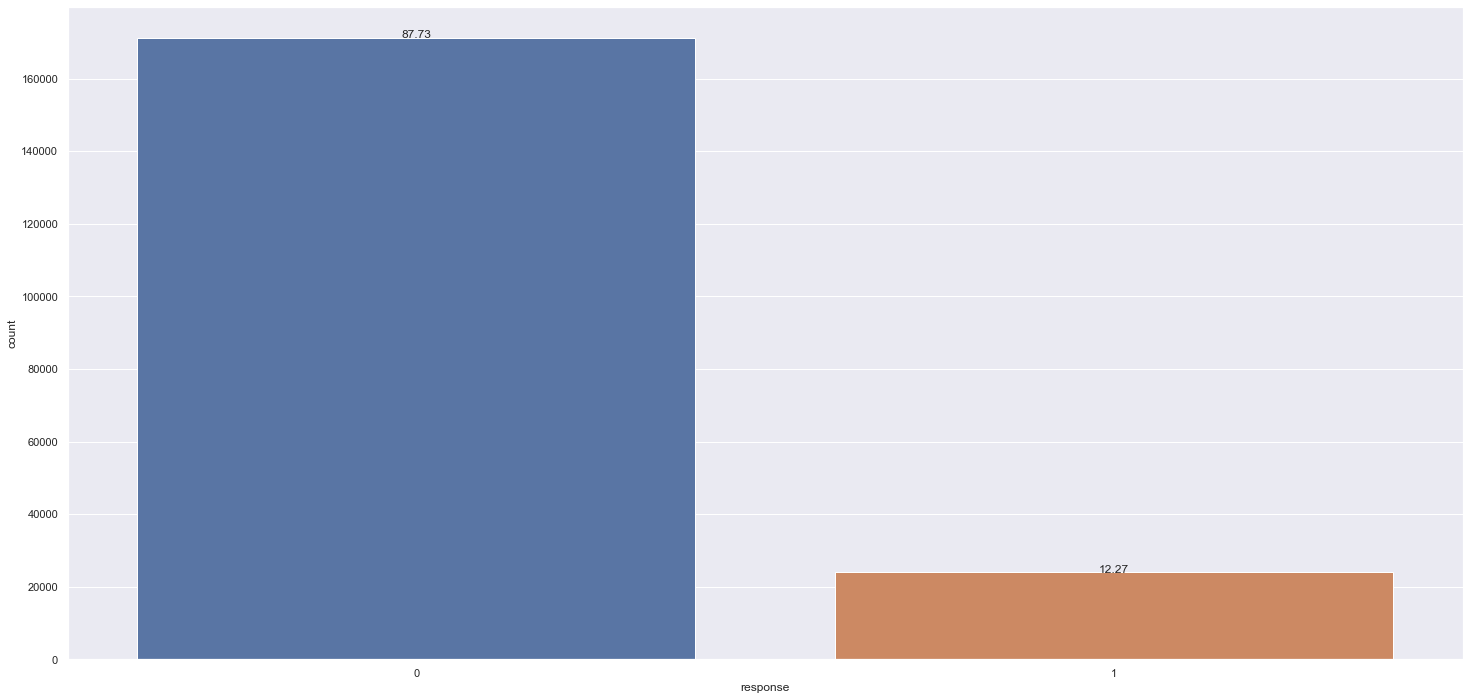

In [43]:
ax=sns.countplot(df_eda['response'])
total=len(df_eda['response'])
graphic_percentage(ax,total)

### 4.1.2. - Numerical Variables

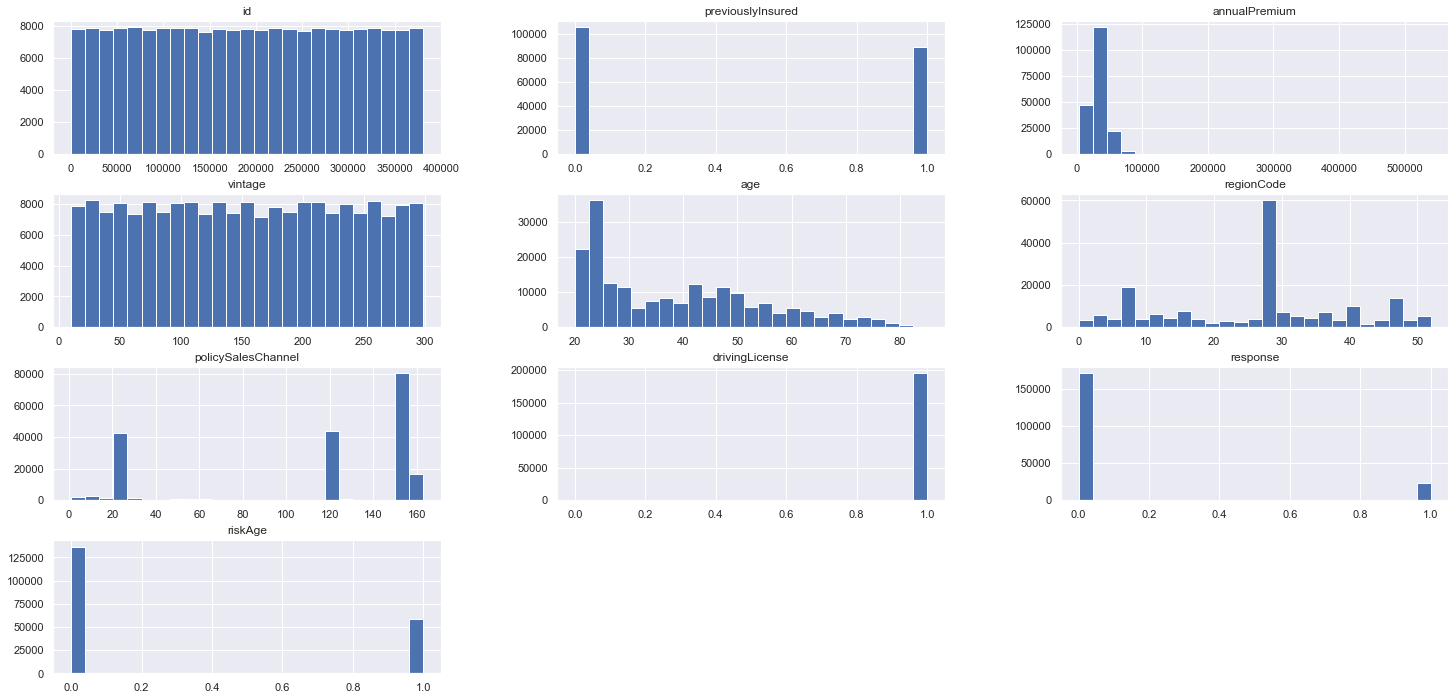

In [46]:
df_eda[numerical_columns].hist(bins=25);

#### Previosly Insured

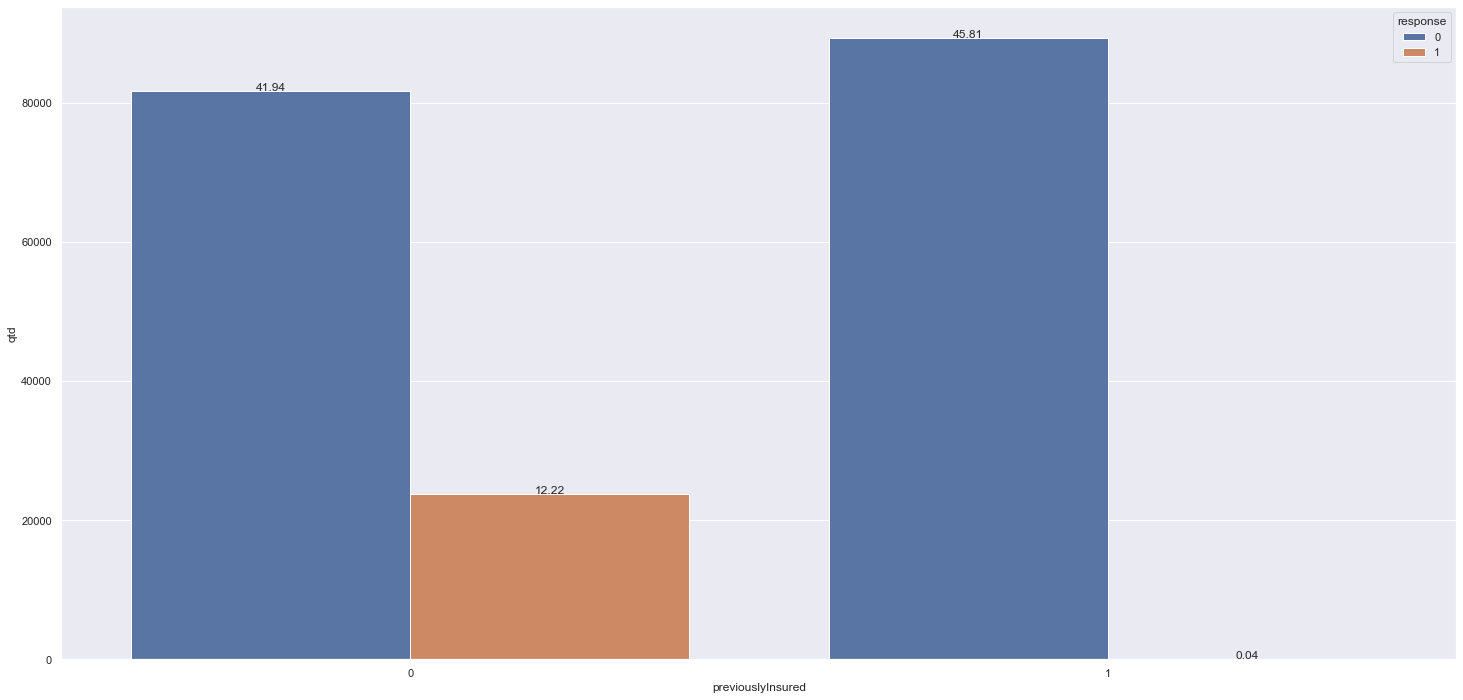

In [48]:
aux=df_eda[['previouslyInsured','response']].groupby(['previouslyInsured','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(x='previouslyInsured',y='qtd',data=aux,hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

#### Annual Premium

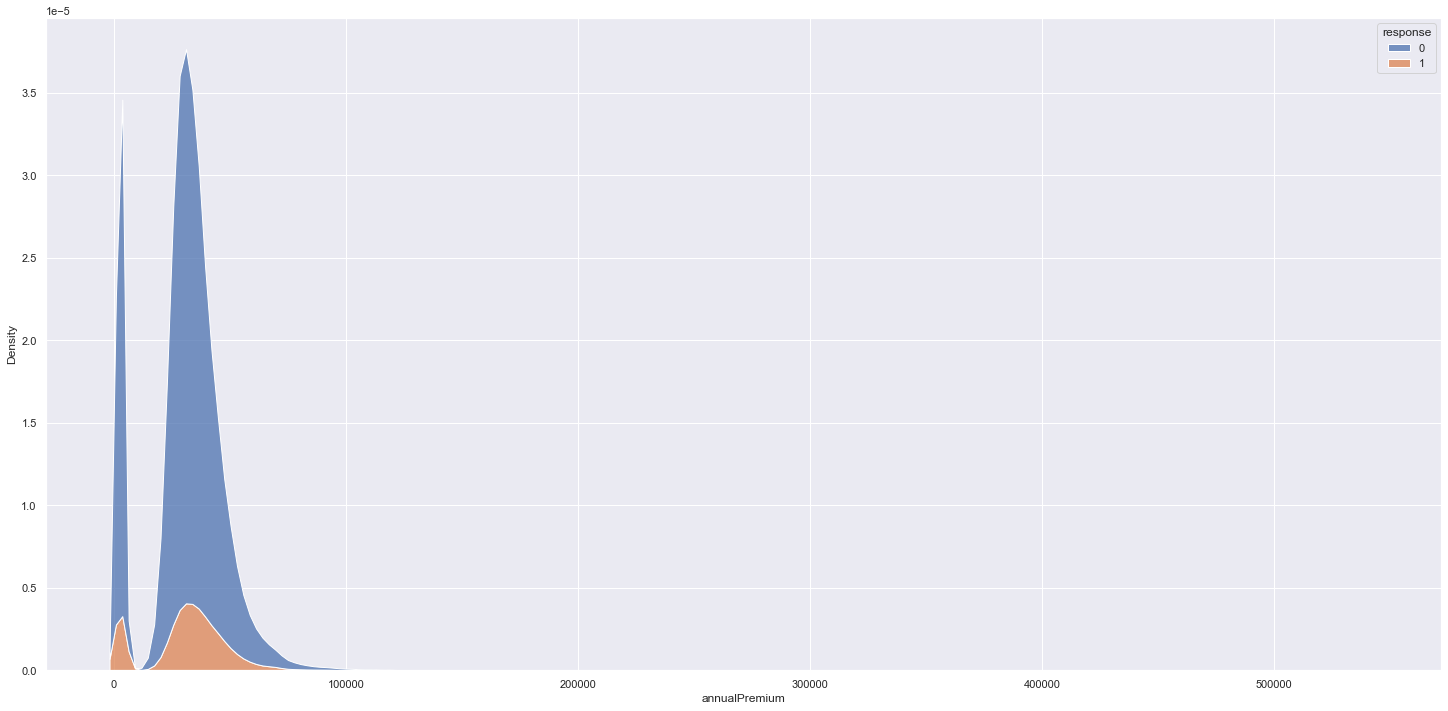

In [97]:
sns.kdeplot(x='annualPremium',data=df_eda,hue='response',multiple='stack');

#### Vintage

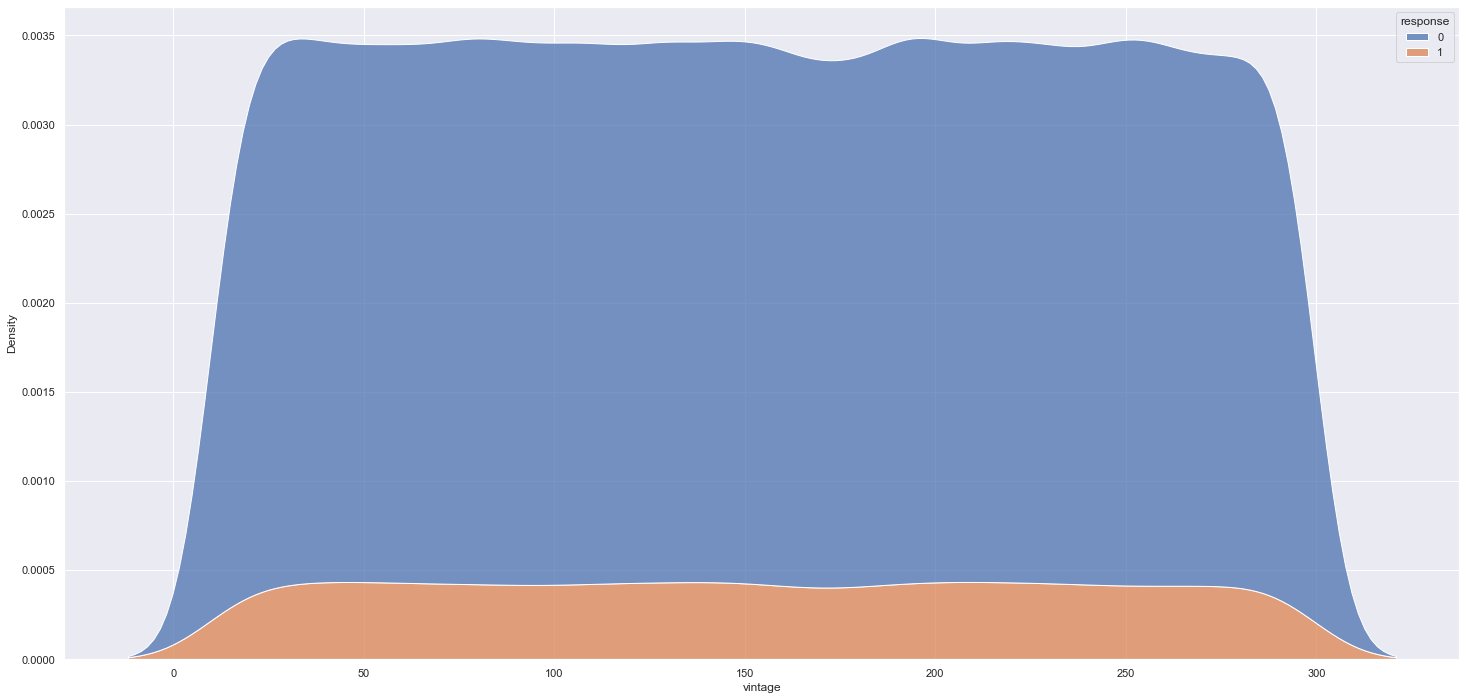

In [99]:
sns.kdeplot(x='vintage',data=df_eda,hue='response',multiple='stack');

#### Age

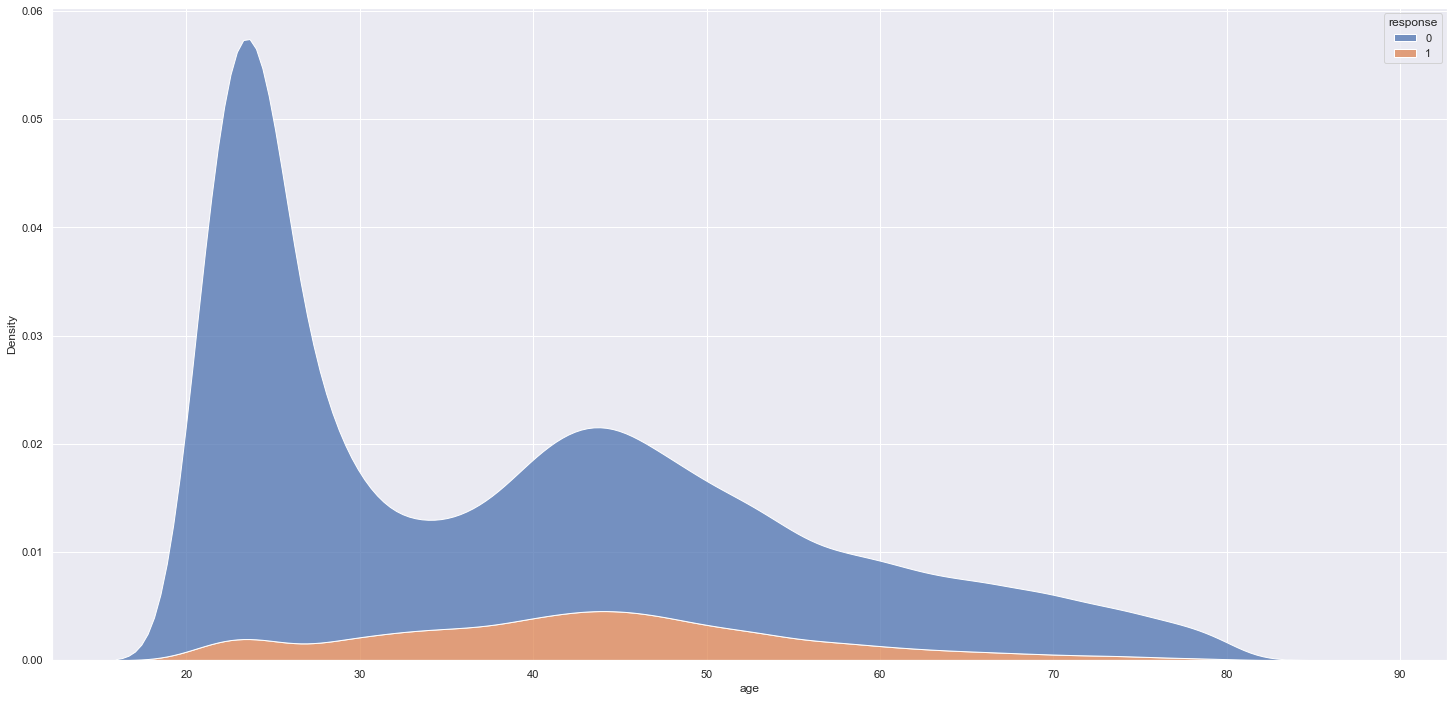

In [96]:
sns.kdeplot(x='age',data=df_eda,hue='response',multiple='stack');

#### Region Code

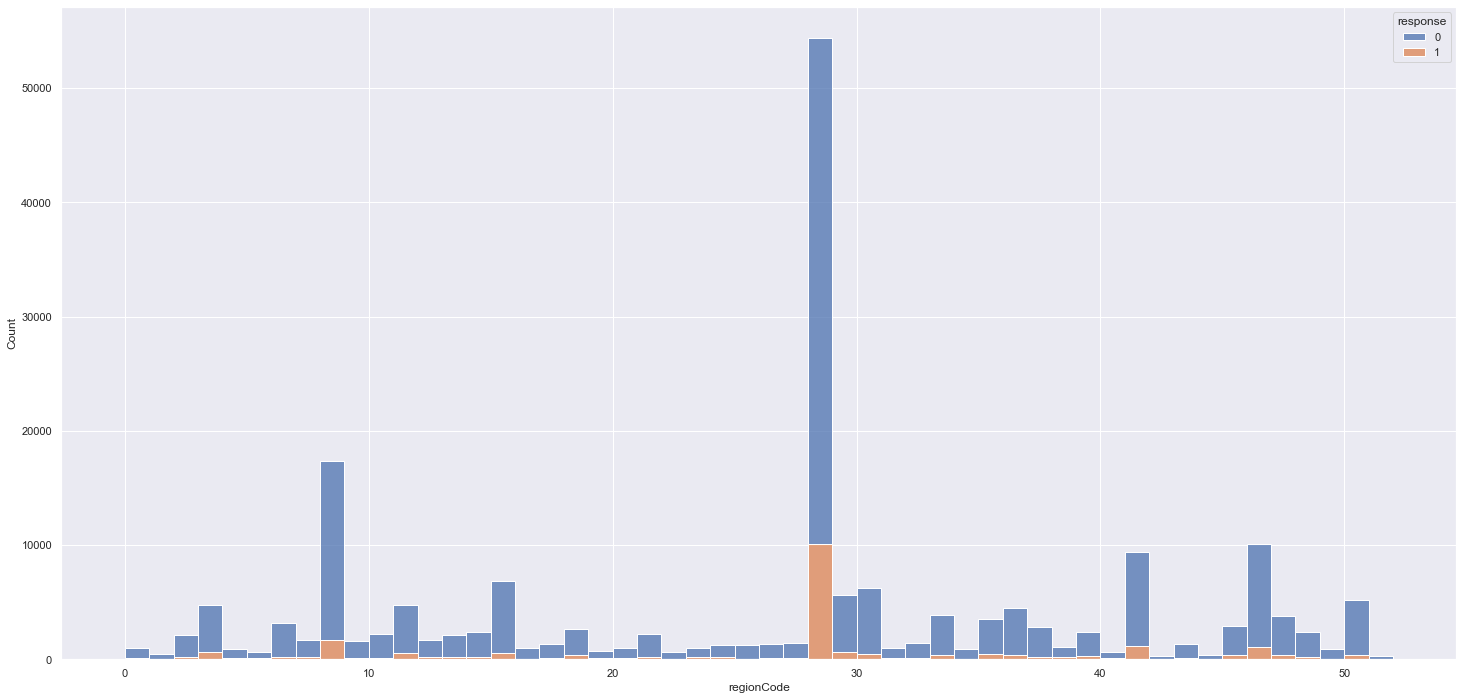

In [65]:
sns.histplot(data=df_eda, x='regionCode', hue='response', multiple='stack', binwidth=1);

#### Policy Sale Channel

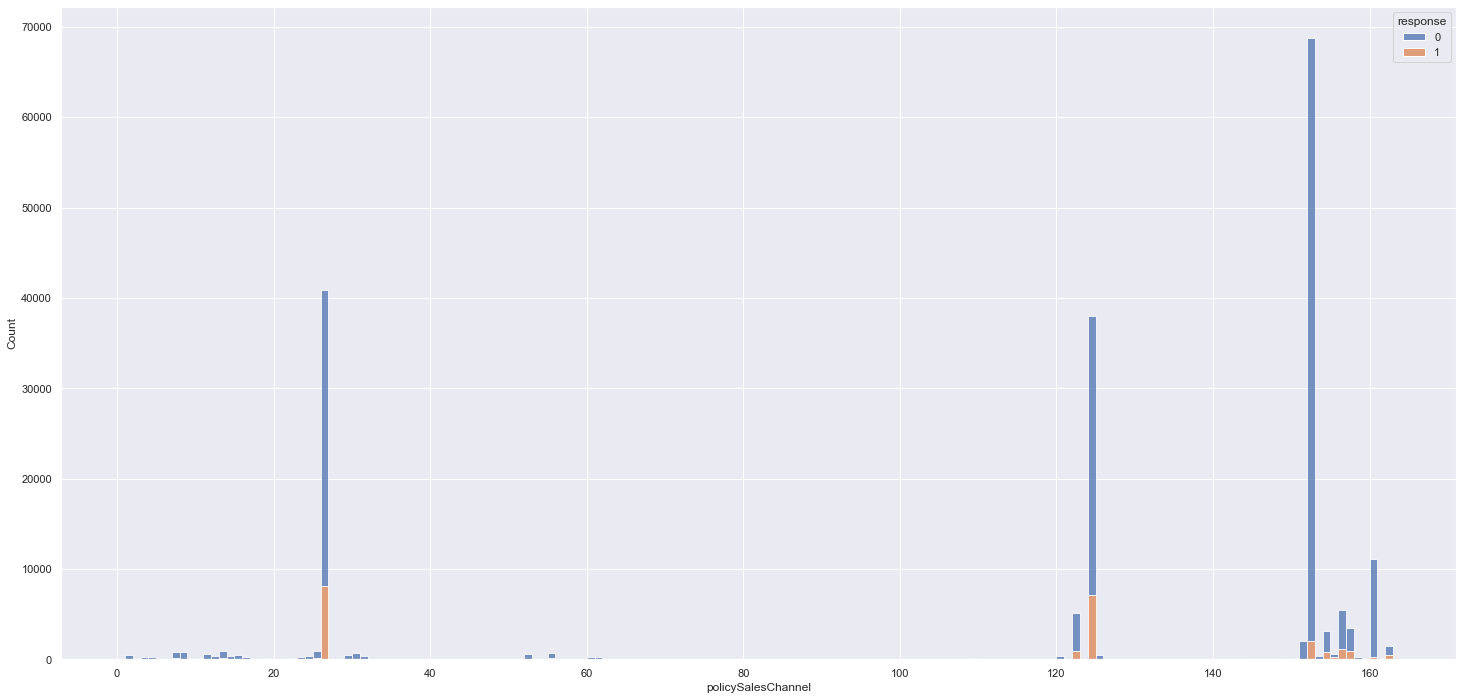

In [70]:
sns.histplot(data=df_eda, x='policySalesChannel', hue='response', multiple='stack', binwidth=1);

#### Risk Age

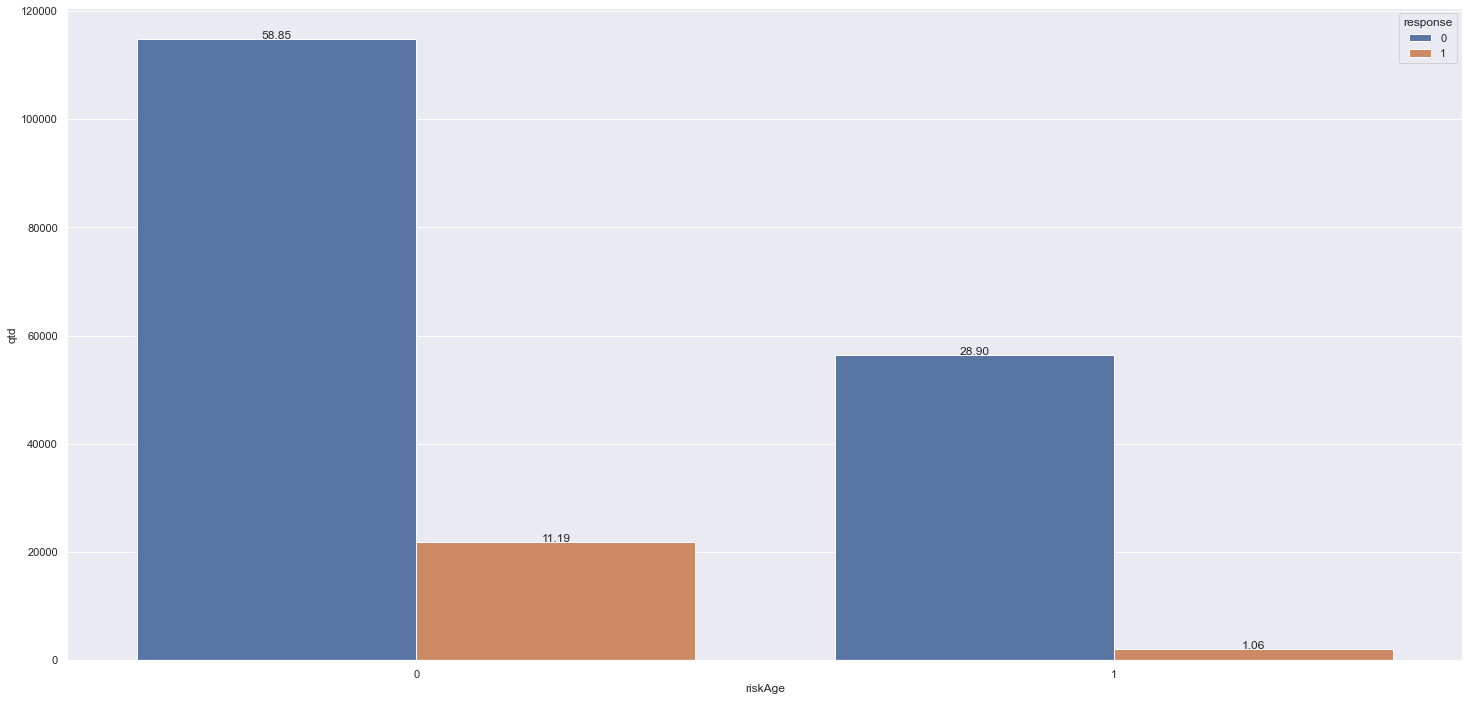

In [71]:
aux=df_eda[['riskAge','response']].groupby(['riskAge','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(x='riskAge',y='qtd',data=aux,hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

## 4.2. Hypotheses Validation

### H1 - Women buy more vehicles insurance than men

**False** - Men (60,82%) have more interest in vehicles insurance than women (39,18%)

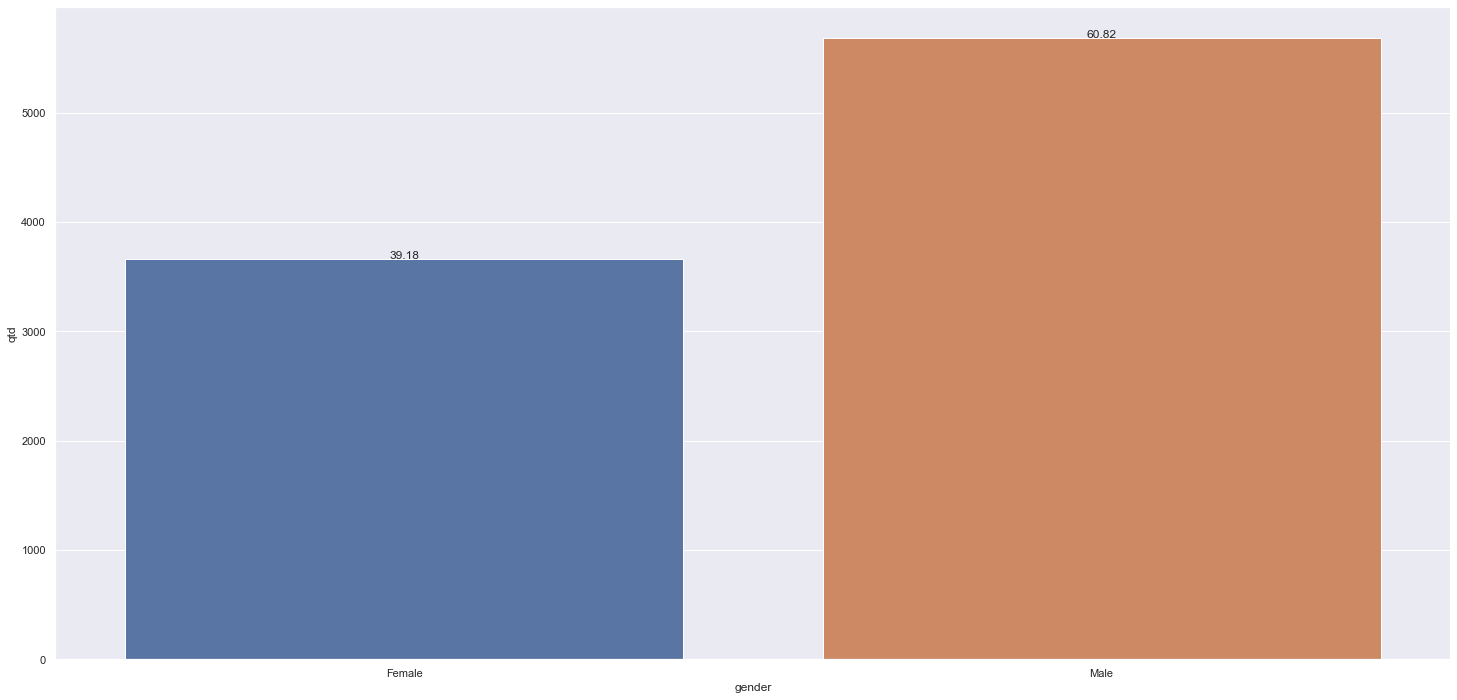

In [33]:
aux=df_eda[df_eda['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)


### H2 - Customer with cars less than 2 years old, have more interest on vehicle insurance

**True** - Customers with cars between 1 and 2 years correspond to 74,34% of interesting in vehicles insurance

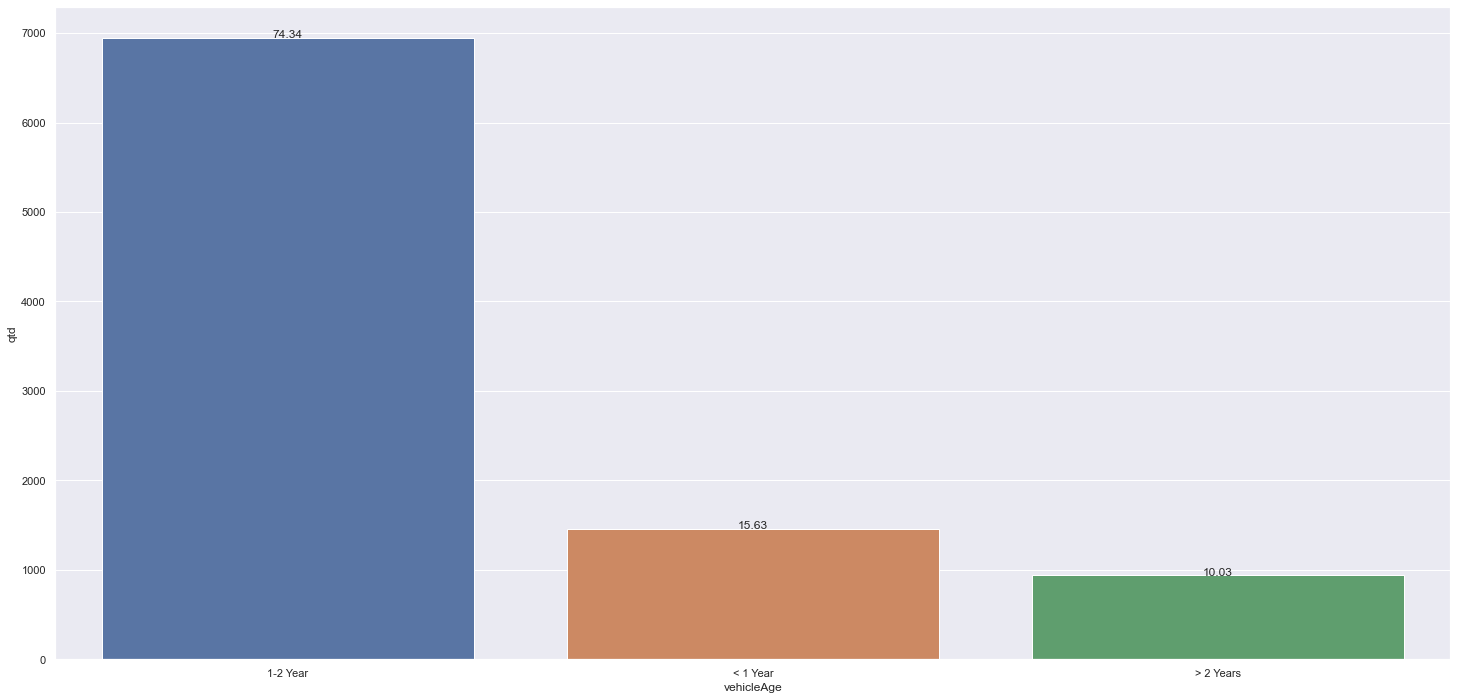

In [34]:
aux=df_eda[df_eda['response']==1]
aux=aux[['vehicleAge']].groupby('vehicleAge').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicleAge',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)


### H3 - Customer without driving license don't have interest in vehicles insurance
**False** - A tiny customers quantity(0,01%) have interest on vehicles insurance, dispite haven't driving license

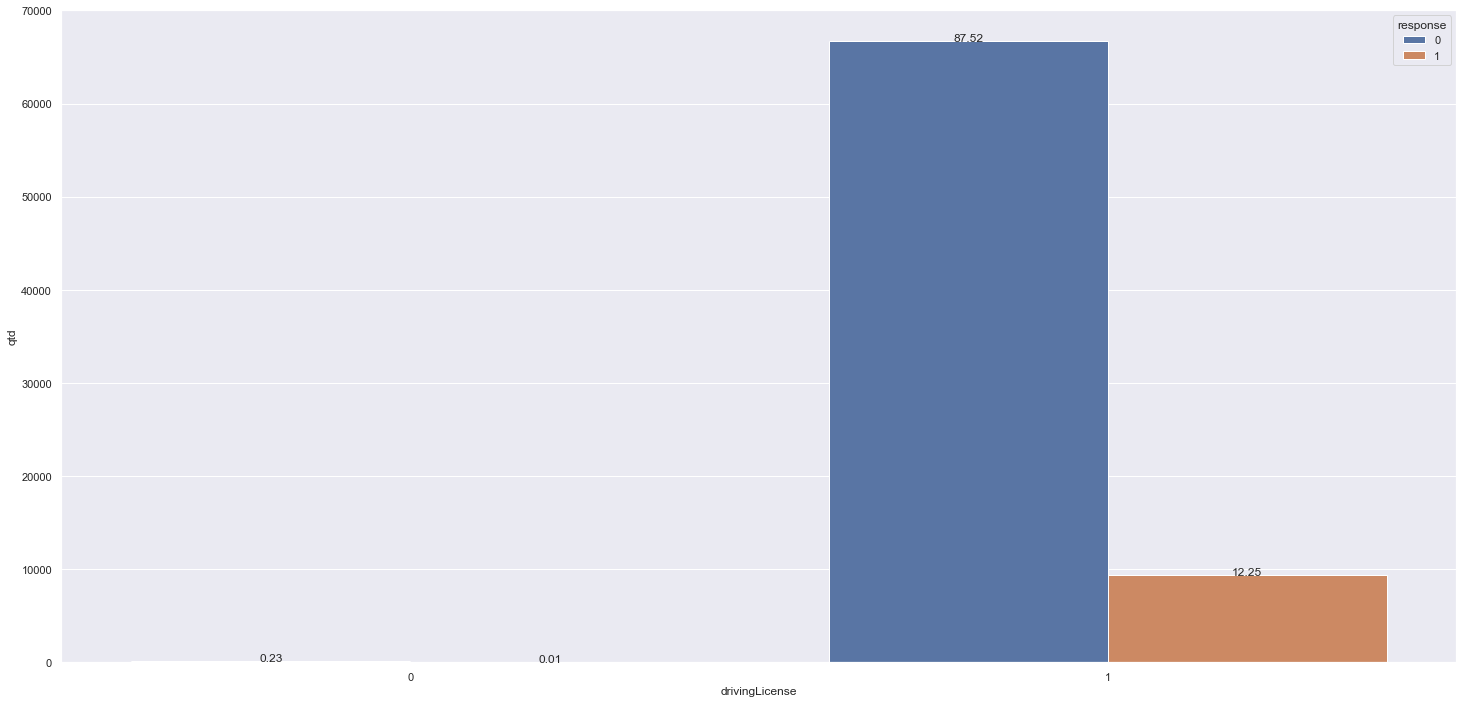

In [35]:
aux=df_eda[['drivingLicense','response']].groupby(['drivingLicense','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='drivingLicense',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)


Because proportion of customer haven't driver license is most smaller than customer have driver license i'll analysing him separated

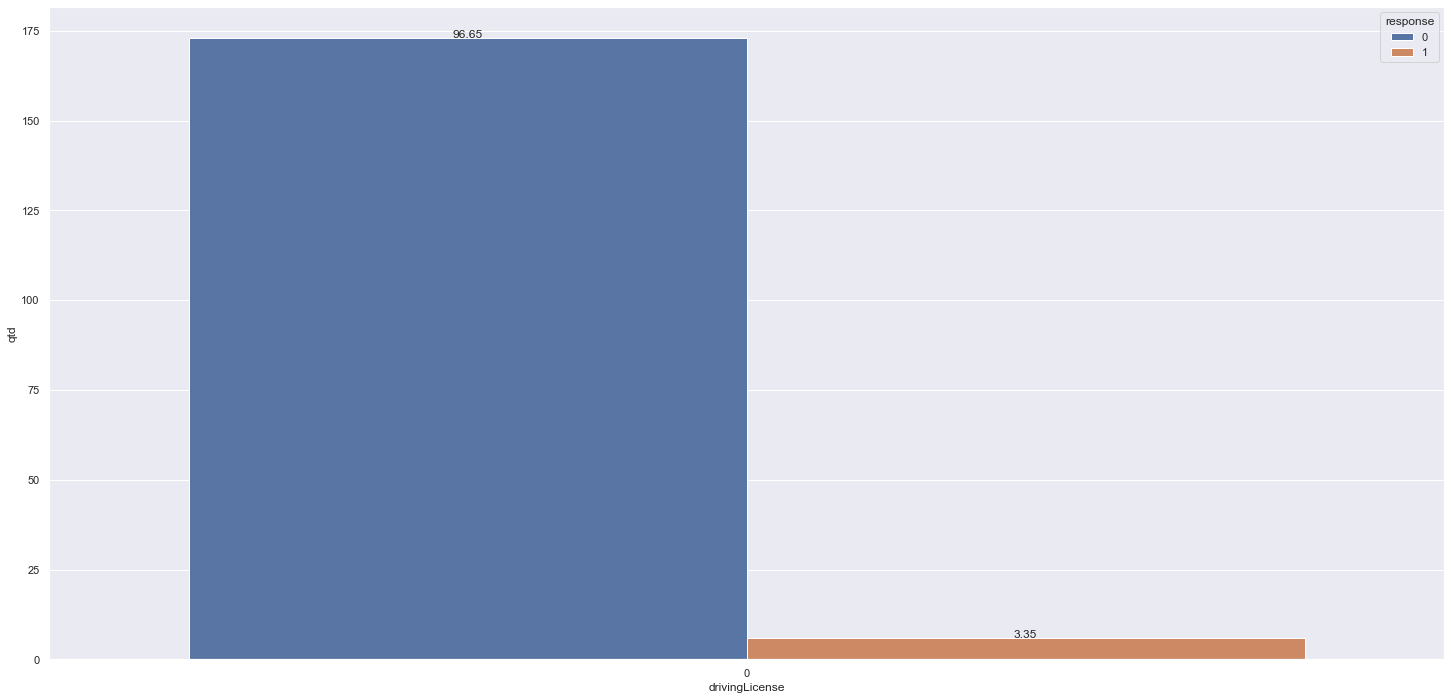

In [36]:
aux=aux[aux['drivingLicense']==0]
ax=sns.barplot(data=aux,x='drivingLicense',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Customers had damage Historical have more interest on vehicle insurance

**True** -  Almost 98% of customer interesting on vehicle insurance had damage historical

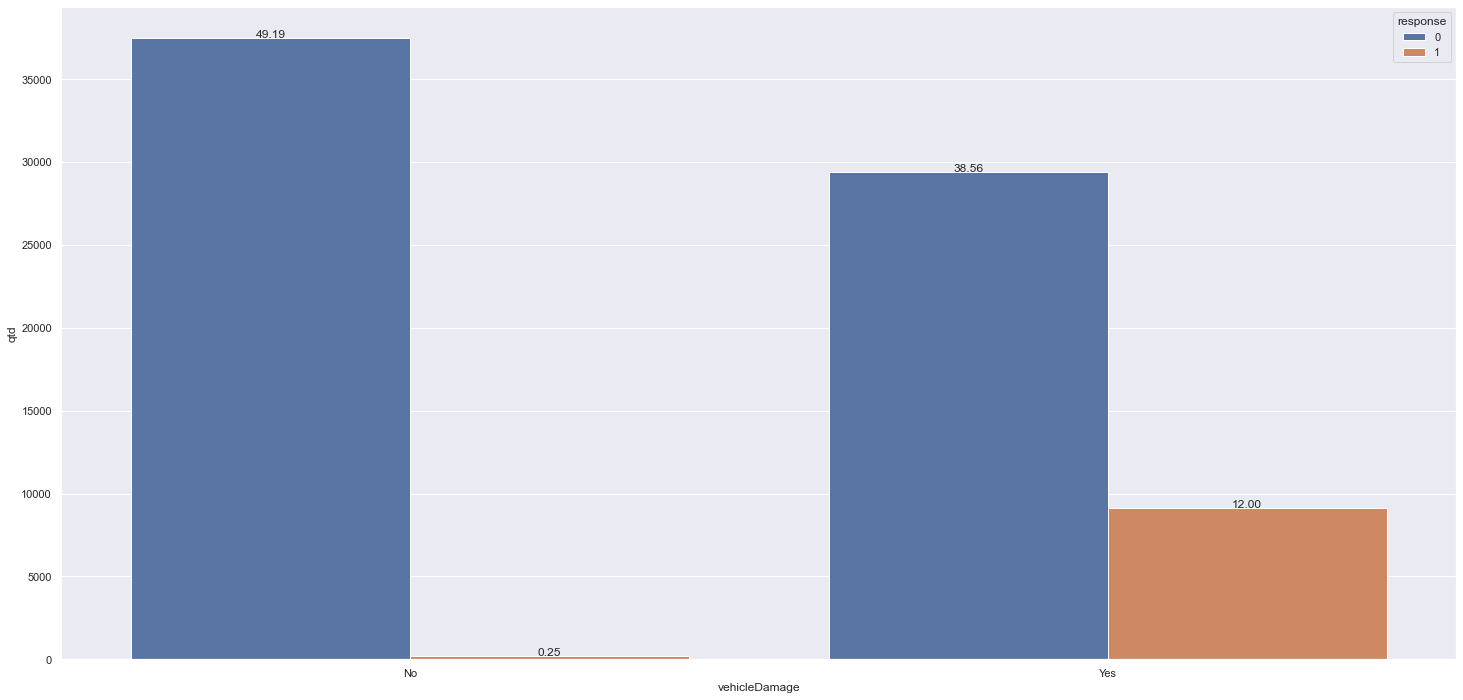

In [37]:
aux=df_eda[['vehicleDamage','response']].groupby(['vehicleDamage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicleDamage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

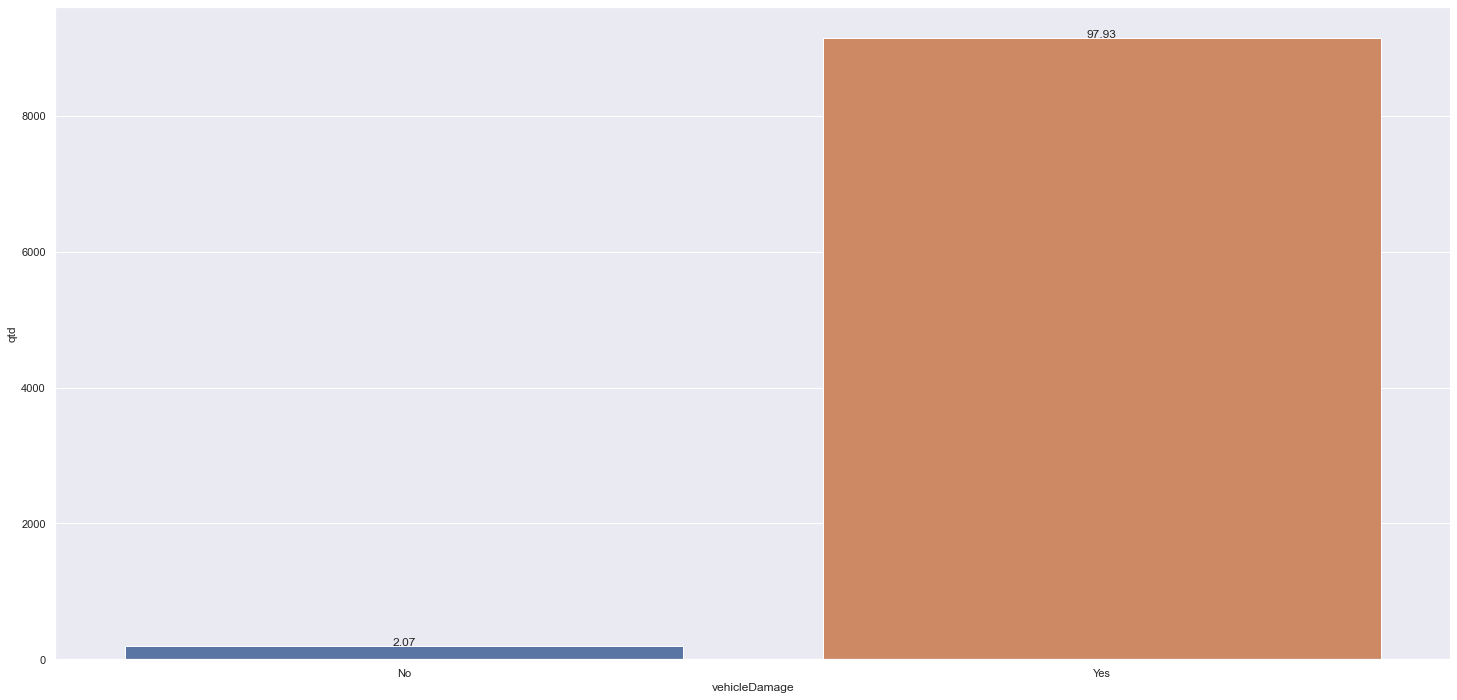

In [38]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicleDamage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5 - Customer older than 30 years old have more interest in vehicles insurance
**True** - Almost 85% of customer interesting on vehicle insurance has more then 30 years old

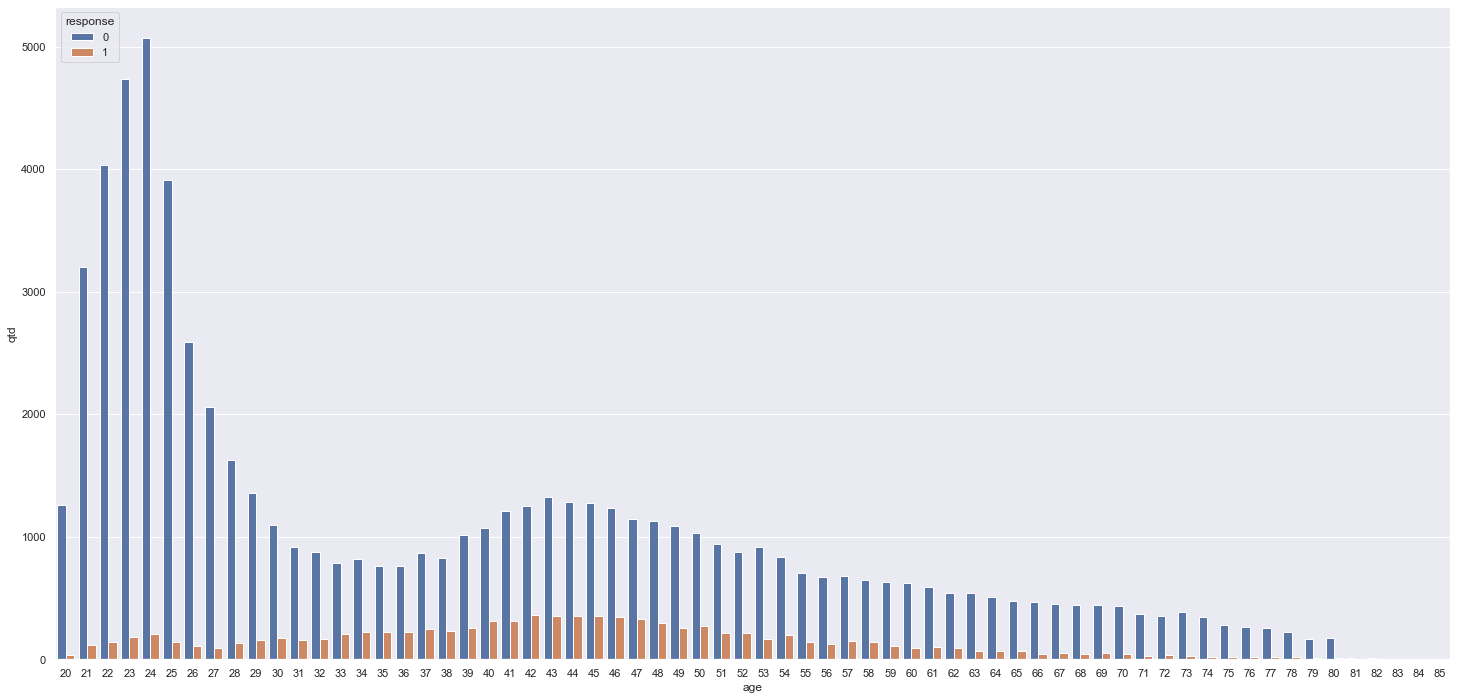

In [45]:
aux=df_eda[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response');

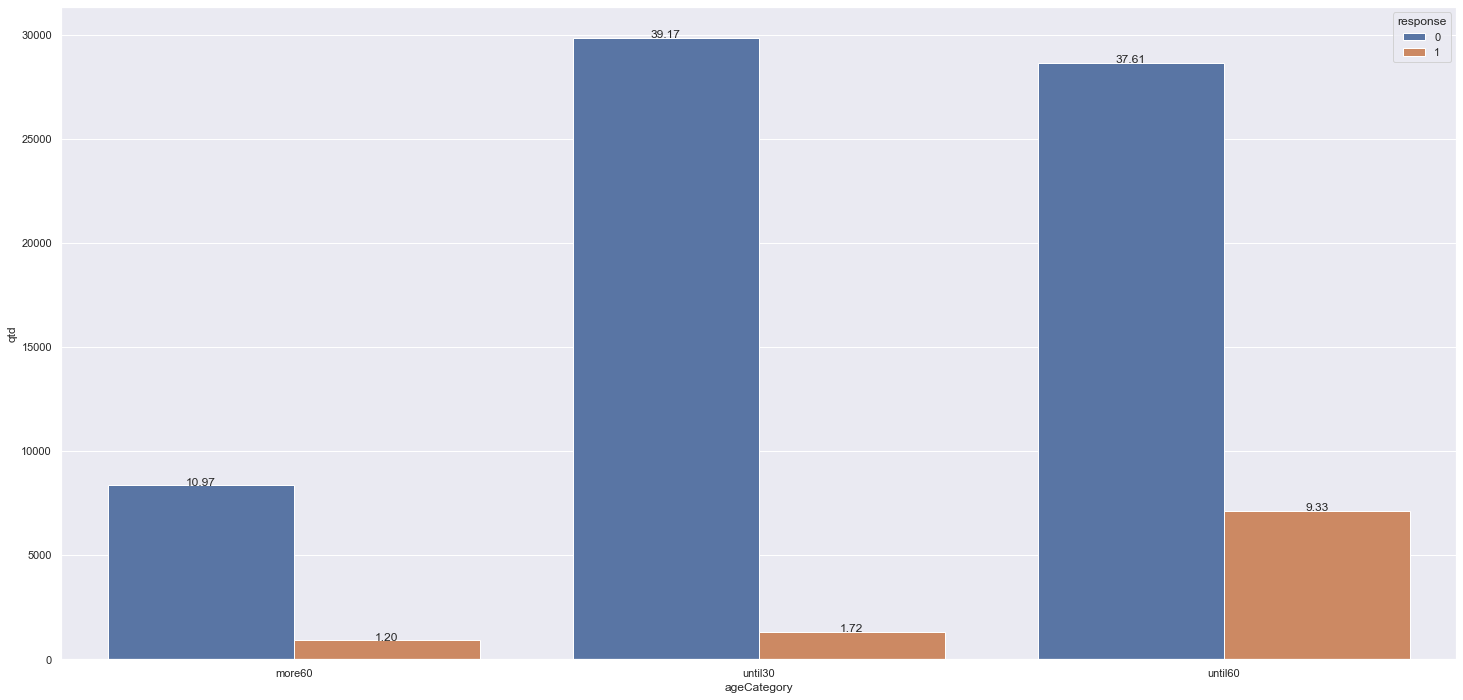

In [46]:
aux=df_eda.copy()
aux['ageCategory']=df_edaub['age'].apply(lambda x: 'until30' if x<30 else 'until60' if x>=30 and x<60 else 'more60')
aux=aux[['ageCategory','response']].groupby(['ageCategory','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='ageCategory',y='qtd',hue='response');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

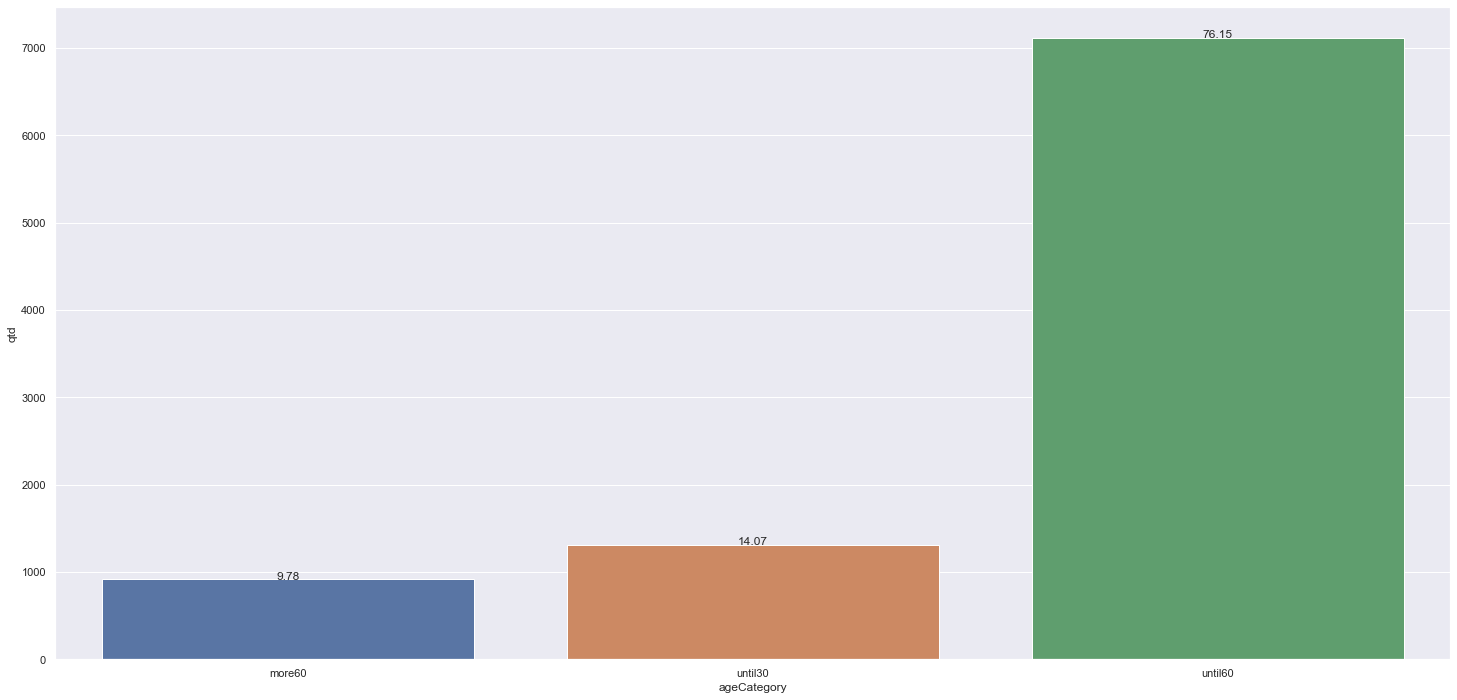

In [47]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='ageCategory',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H6 - Customer that paid between 24405 a 39400 on Annual Premium have more interest in vehicles insurance
**True** - Customer that paid between 24405 a 39400 on Annual Premium correspond a 46,52% of customer interesting in vehicles insurance

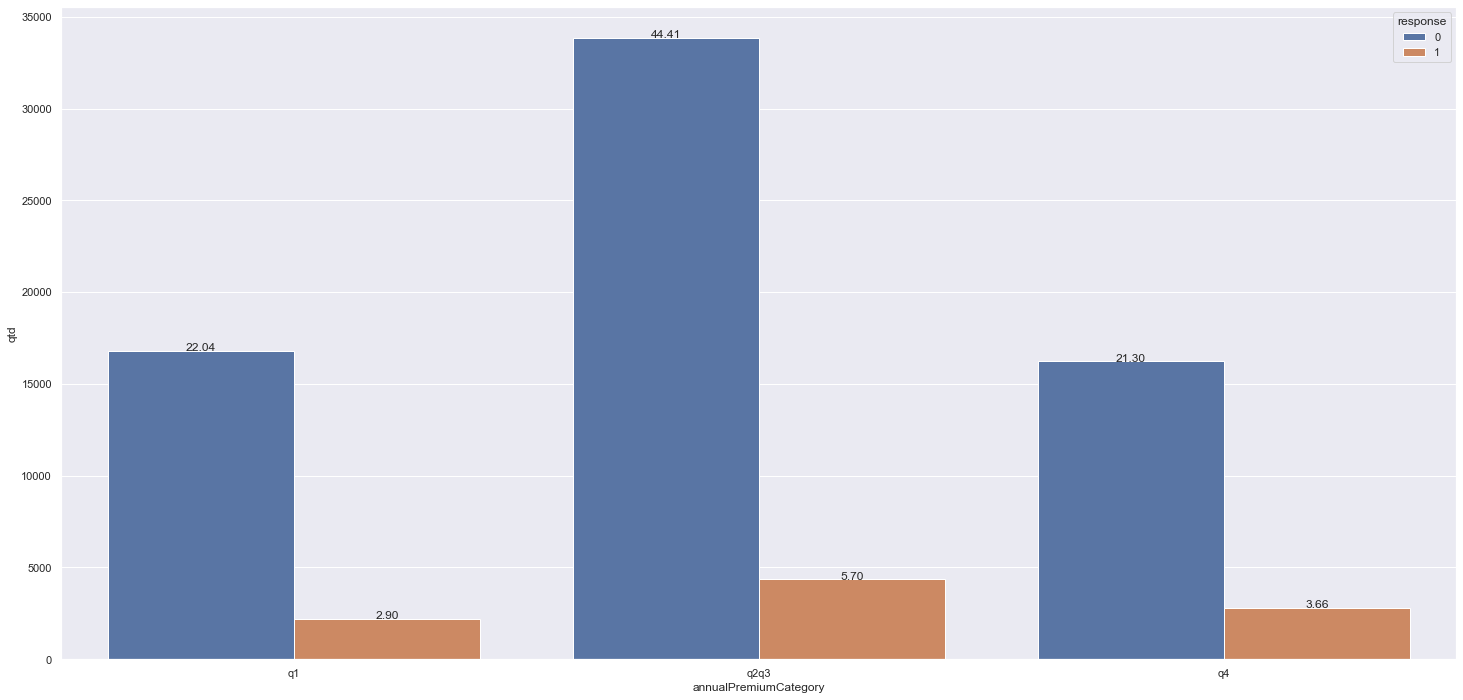

In [42]:
aux = df_eda.copy()
aux['annualPremiumCategory'] =aux['annualPremium'].apply(lambda x: 'q1' if x<24405 else 'q4' if x>39400 else 'q2q3')
aux=aux[['annualPremiumCategory','response']].groupby(['annualPremiumCategory','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='annualPremiumCategory',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

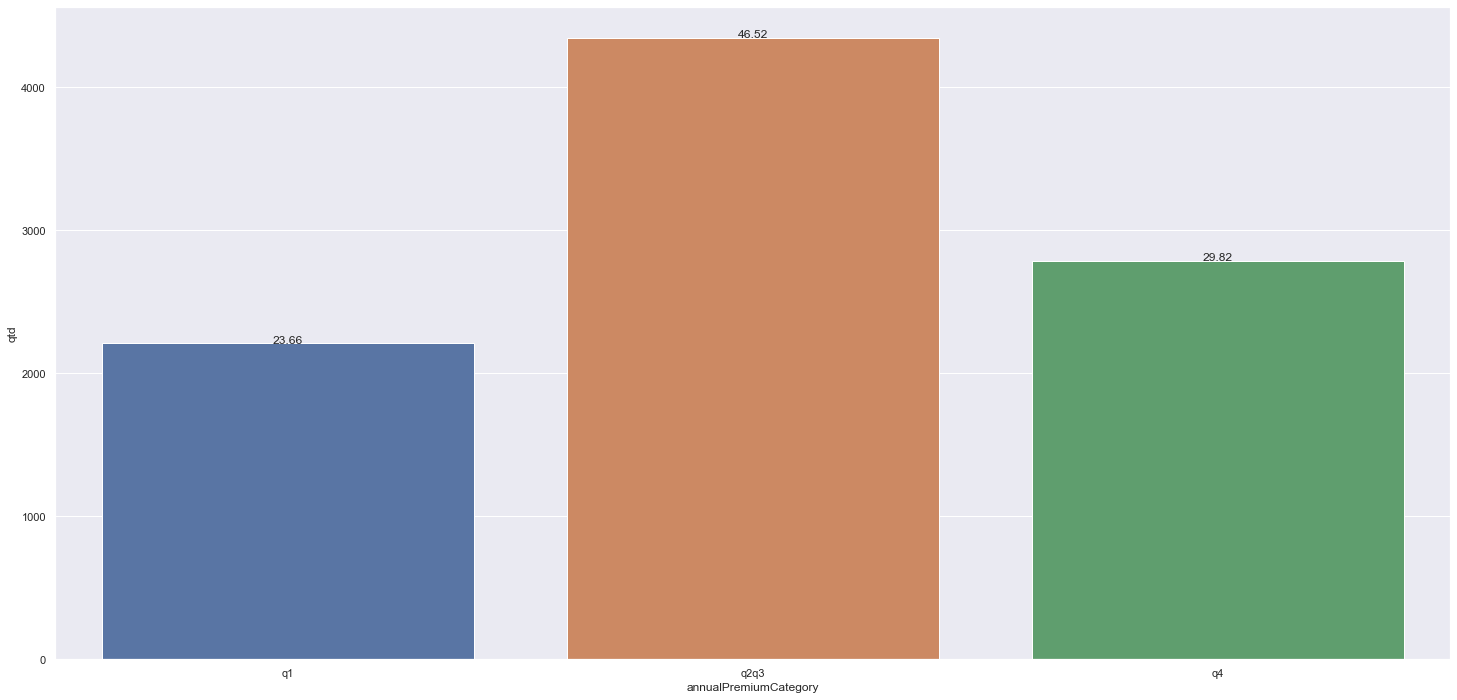

In [43]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='annualPremiumCategory',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

## 4.3. Bivariate Analysis

### Annual Premium by Region Code

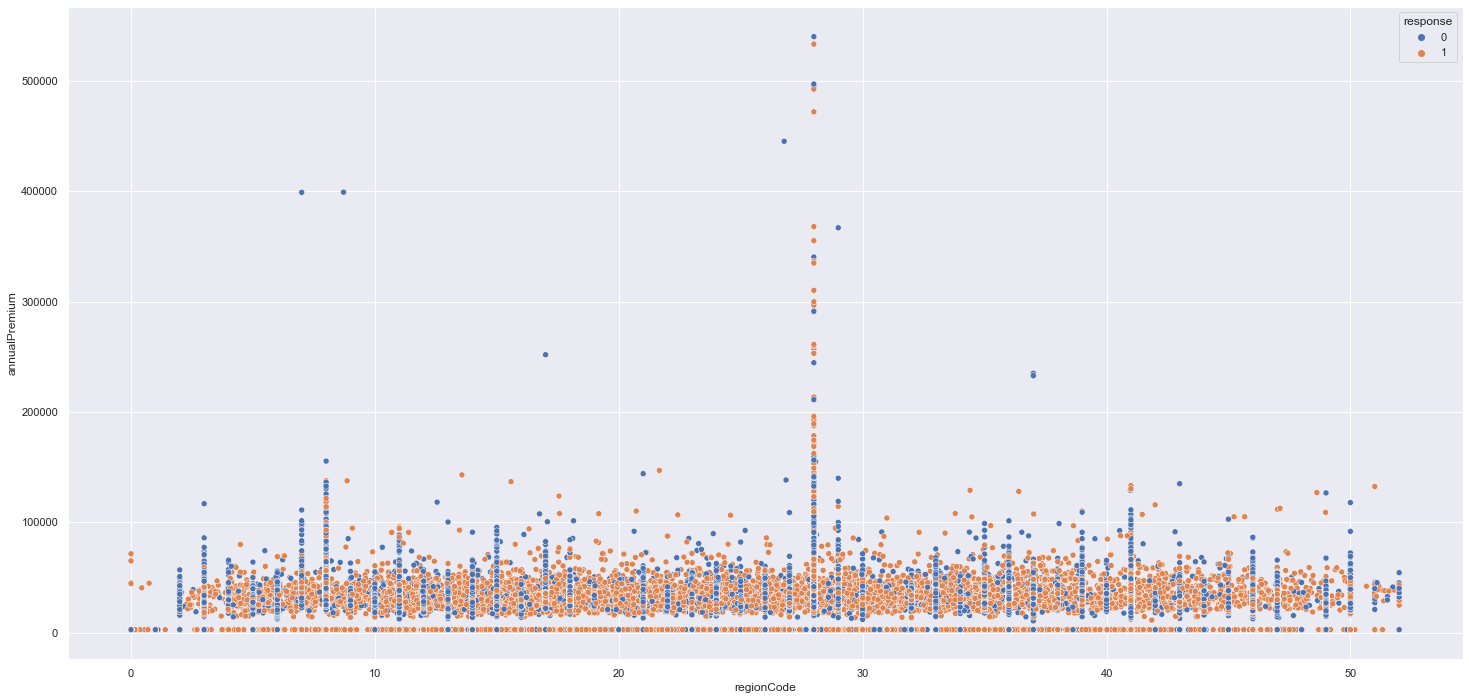

In [88]:
sns.scatterplot(x='regionCode',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Policy Sales Channel

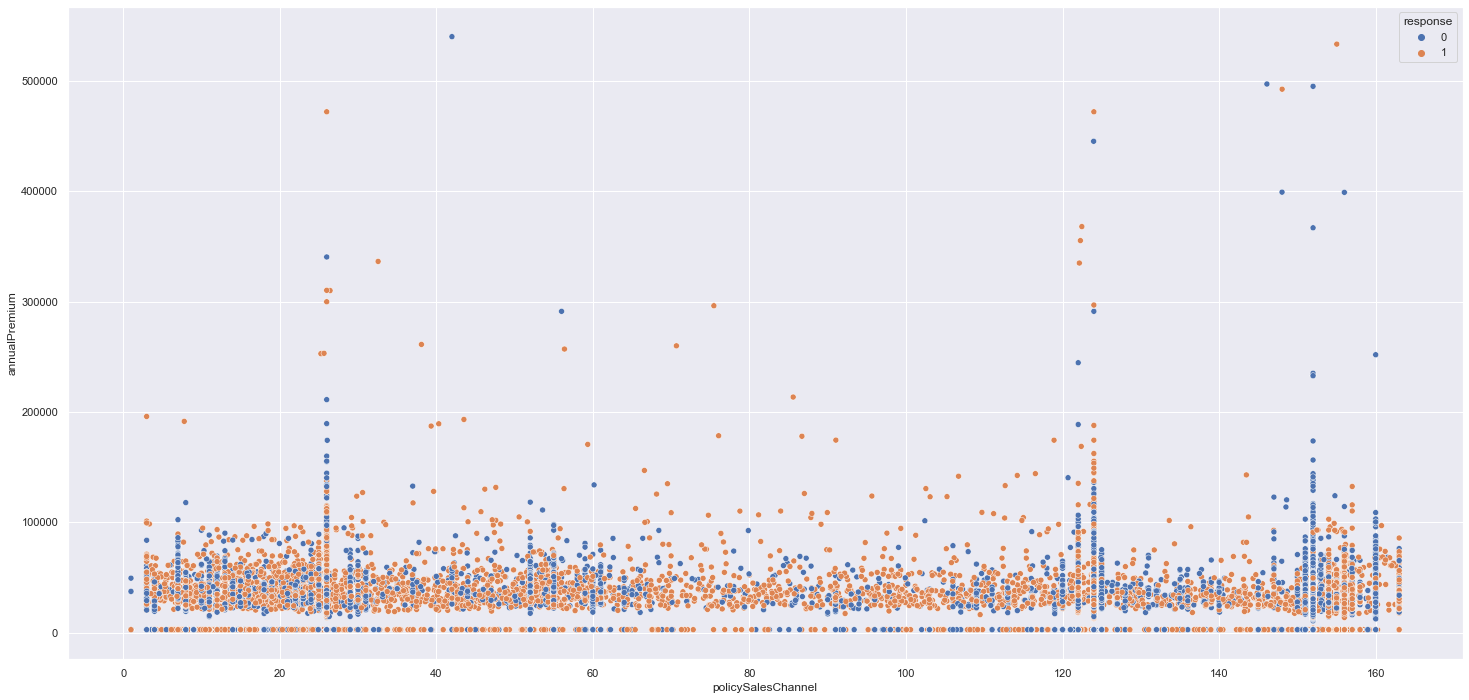

In [87]:
sns.scatterplot(x='policySalesChannel',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Previously Insured

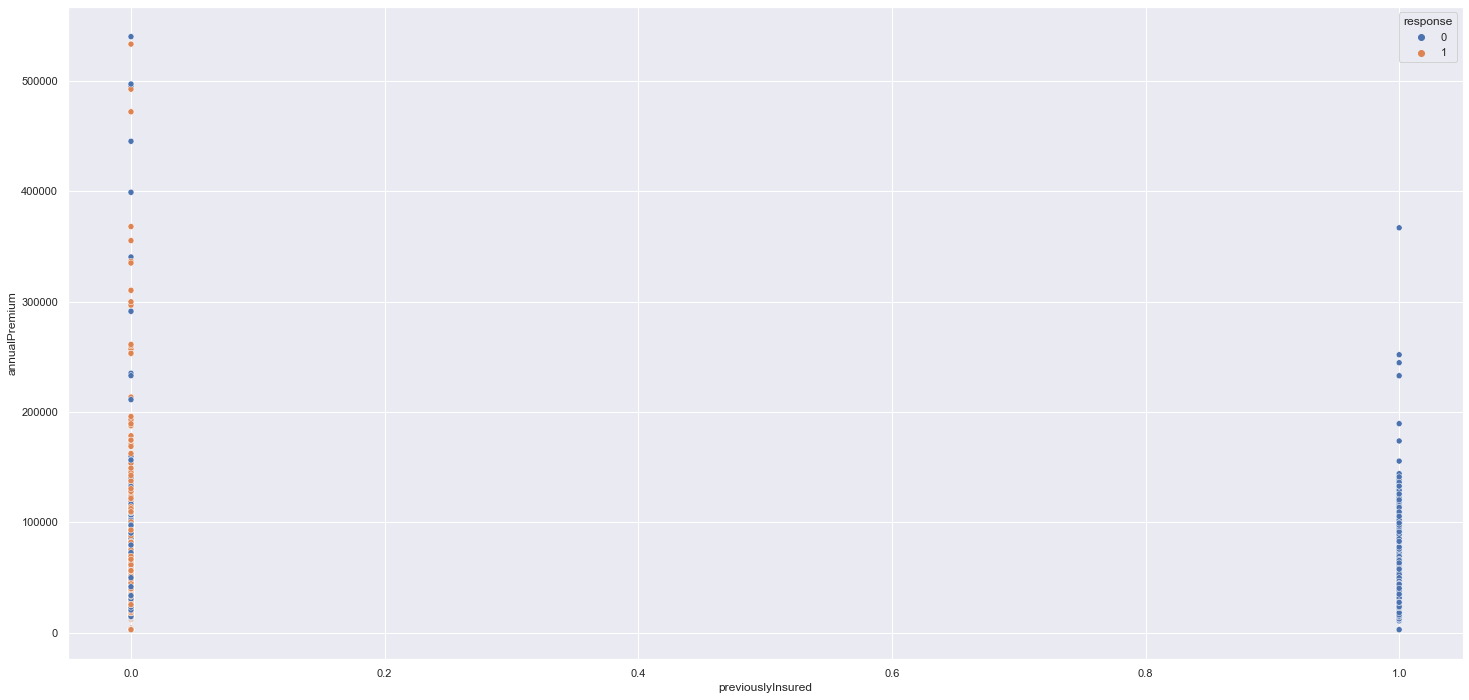

In [89]:
sns.scatterplot(x='previouslyInsured',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Vintage Month

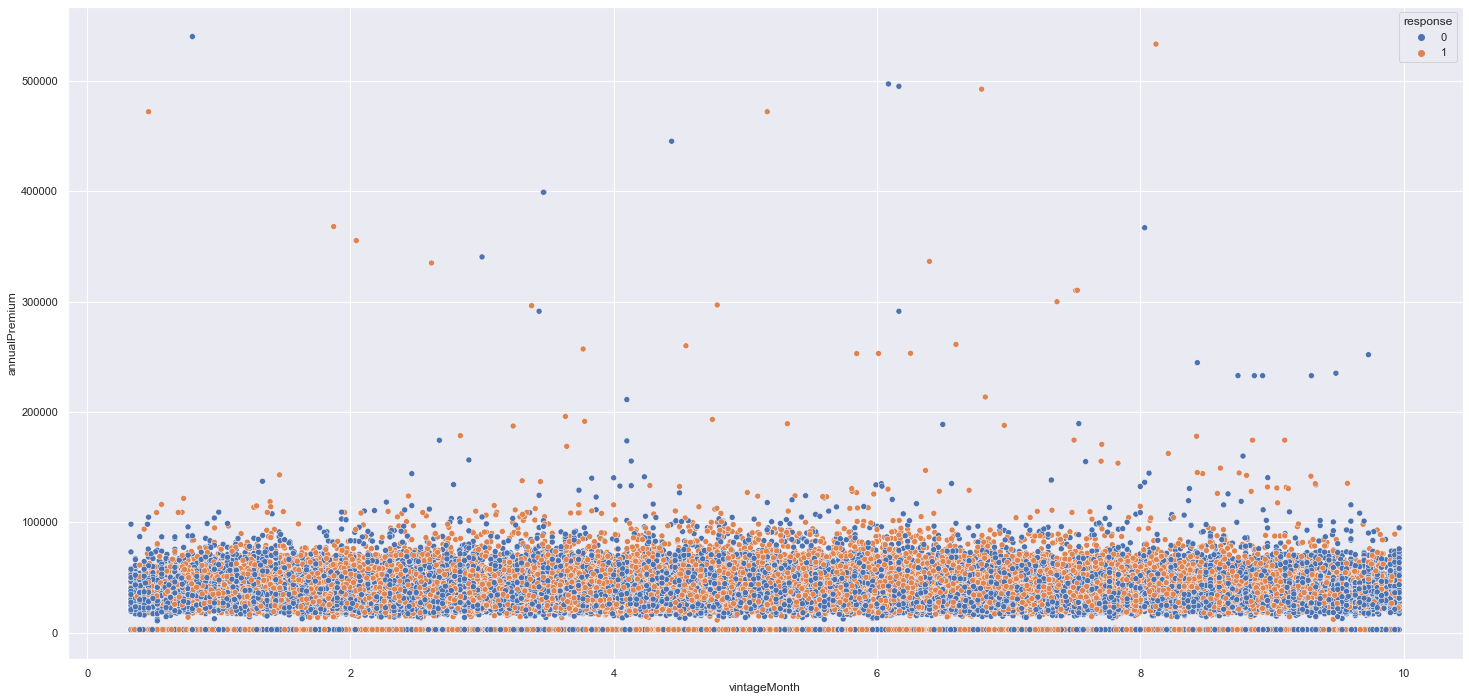

In [90]:
sns.scatterplot(x='vintageMonth',y='annualPremium',data=df_eda,hue='response');

### Annual Premium by Age

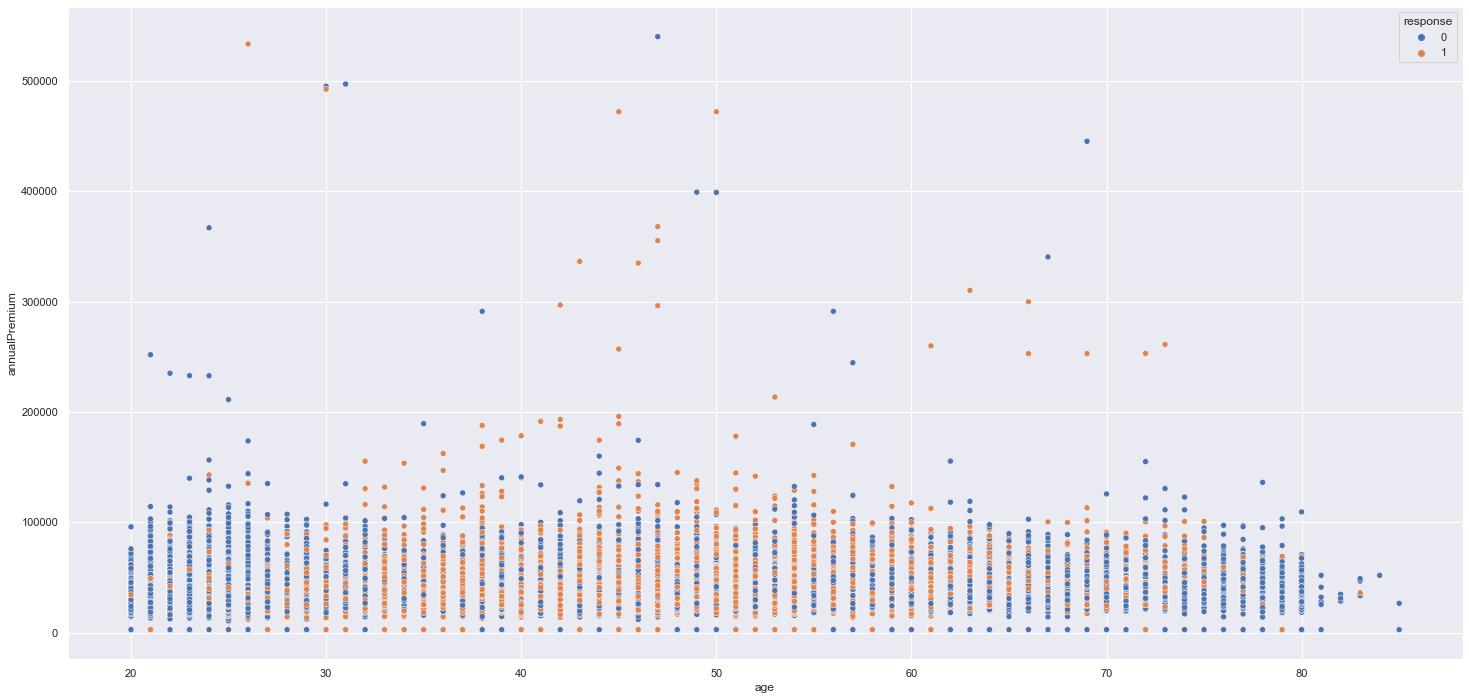

In [91]:
sns.scatterplot(x='age',y='annualPremium',data=df_eda,hue='response');

## 4.4. Multivarible Analysis

### 4.3.1. Numerical Attributes

<AxesSubplot:>

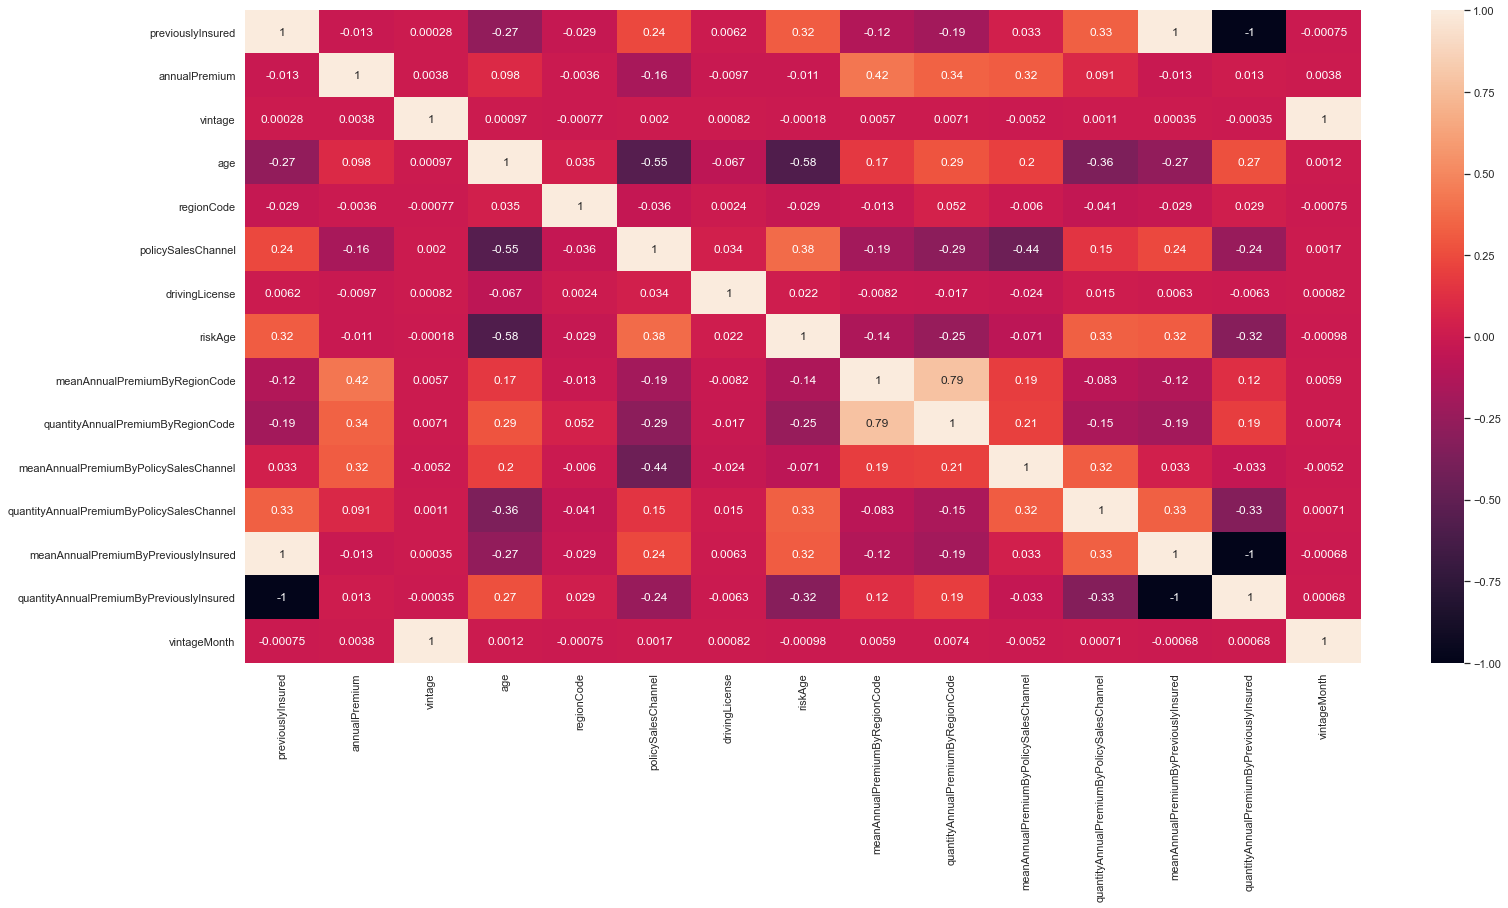

In [71]:
aux= df_eda[numerical_columns].corr()
sns.heatmap(aux,annot=True)

### 4.3.2. Categorical Attributes

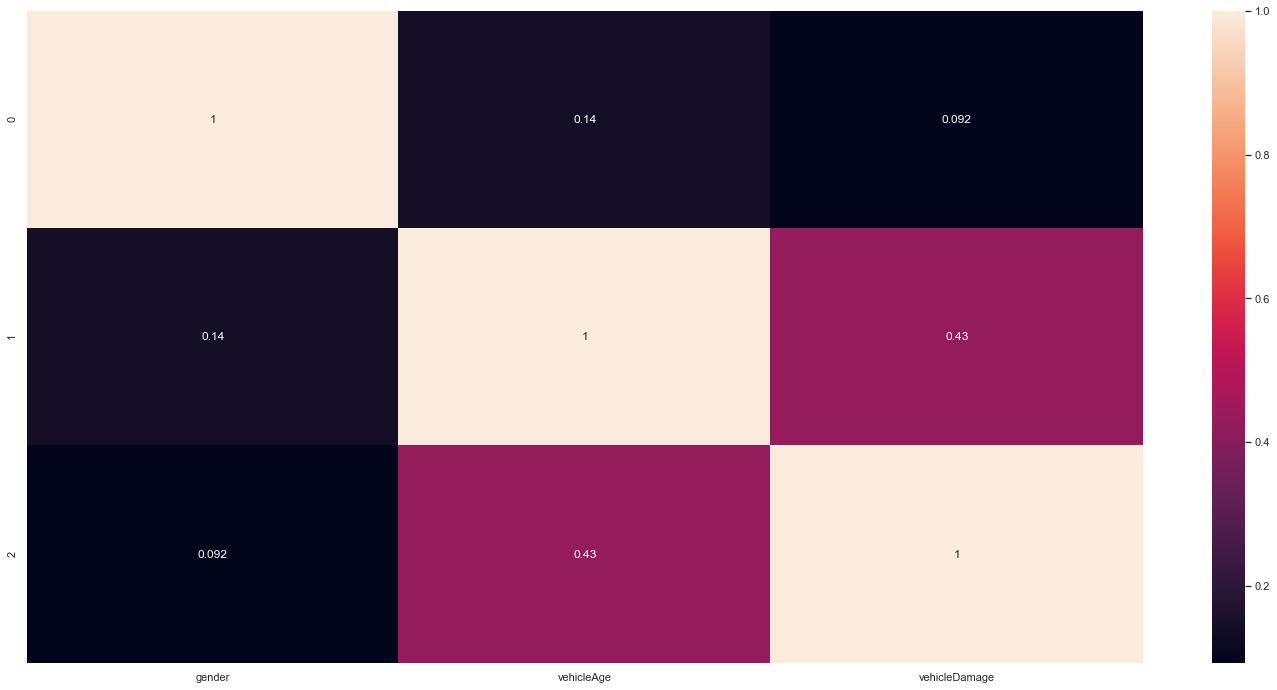

In [72]:
aux=pd.DataFrame(corr_cramer_v(df_eda[categorical_columns]))
sns.heatmap(aux,annot=True);

## 4.4. Hypotheses Insights

**Feature Relevants** 

In my analysis the feature did showed more relevants to modeling the fenomeno are **vehicle Damage, previously insured, vehicle age, driving license,risk Age, age and Gender, respectively**

In step Feature Selection i'll confirm my analysis using some Algorithms to calculate how relevants this features are.

# 5.0. Data Preparation

In [29]:
df_dp=df_fe.copy()
numerical_columns=df_dp.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_columns=df_dp.select_dtypes(exclude=['int64','float64']).columns.tolist()

In [30]:
df_fe.head()

id  previouslyInsured  annualPremium  vintage  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage  response  riskAge
321817  285364                  0      2630.0000       72    Male   45      4.0000            156.0000               1   1-2 Year           Yes         0        0
3201     25628                  1     39437.0000       83  Female   24     11.0000            152.0000               1   < 1 Year            No         0        1
214291  186976                  0      2630.0000      197    Male   56     26.0000            157.0000               1   1-2 Year           Yes         0        0
236011  360502                  0      2630.0000       67  Female   59     48.0000            124.0000               1   1-2 Year           Yes         0        0
317825  253554                  0     40717.0000      137  Female   41     13.0000             26.0000               1   1-2 Year           Yes         0        0

## 5.1. Numericals

In [31]:
df_dp.head()

id  previouslyInsured  annualPremium  vintage  gender  age  regionCode  policySalesChannel  drivingLicense vehicleAge vehicleDamage  response  riskAge
321817  285364                  0      2630.0000       72    Male   45      4.0000            156.0000               1   1-2 Year           Yes         0        0
3201     25628                  1     39437.0000       83  Female   24     11.0000            152.0000               1   < 1 Year            No         0        1
214291  186976                  0      2630.0000      197    Male   56     26.0000            157.0000               1   1-2 Year           Yes         0        0
236011  360502                  0      2630.0000       67  Female   59     48.0000            124.0000               1   1-2 Year           Yes         0        0
317825  253554                  0     40717.0000      137  Female   41     13.0000             26.0000               1   1-2 Year           Yes         0        0

In [32]:
rs=pp.RobustScaler()
mms=pp.MinMaxScaler()
ohe=OneHotEncoder(cols=categorical_columns, use_cat_names=True)

In [33]:
def dp_numericals(df_dp):
    df_dp['annualPremium']=rs.fit_transform(df_dp[['annualPremium']])

    df_dp['vintage']=mms.fit_transform(df_dp[['vintage']])
    df_dp['age']=mms.fit_transform(df_dp[['age']])
    df_dp['vintage']=mms.fit_transform(df_dp[['vintage']])
    return df_dp

In [34]:
df_dp=dp_numericals(df_dp)

## 5.2. Categorical

In [35]:
fe_regionCode=frequency_enconding(df_dp,'regionCode')
df_dp['regionCode']=df_dp['regionCode'].map(fe_regionCode)

fe_policySalesChannel=frequency_enconding(df_dp,'policySalesChannel')
df_dp['policySalesChannel']=df_dp['policySalesChannel'].map(fe_policySalesChannel)

fe_drivingLicense=frequency_enconding(df_dp,'drivingLicense')
df_dp['drivingLicense']=df_dp['drivingLicense'].map(fe_drivingLicense)

fe_riskAge=frequency_enconding(df_dp,'riskAge')
df_dp['riskAge']=df_dp['riskAge'].map(fe_riskAge)

fe_previouslyInsured=frequency_enconding(df_dp,'previouslyInsured')
df_dp['previouslyInsured']=df_dp['previouslyInsured'].map(fe_previouslyInsured)

In [36]:
y_dp=df_dp['response']
df_dp=ohe.fit_transform(df_dp.drop(['response'],axis=1))
df_dp=df_dp.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})
df_dp['response']=y_dp
df_dp.head()

id  previouslyInsured  annualPremium  vintage  gender_Male  gender_Female    age  regionCode  policySalesChannel  drivingLicense  b1and2  m1  M2  vehicleDamage_Yes  vehicleDamage_No  riskAge  response
321817  285364             0.5418        -1.9360   0.2145            1              0 0.3846      0.0048              0.0281          0.9979       1   0   0                  1                 0   0.7006         0
3201     25628             0.4582         0.5194   0.2526            0              1 0.0615      0.0246              0.3527          0.9979       0   1   0                  0                 1   0.2994         0
214291  186976             0.5418        -1.9360   0.6471            1              0 0.5538      0.0068              0.0175          0.9979       1   0   0                  1                 0   0.7006         0
236011  360502             0.5418        -1.9360   0.1972            0              1 0.6000      0.0122              0.1944          0.9979       1   0   0                  1                 0   0.7006         0
317825  253554             0.5418         0.6048   0.4394            0              1 0.3231      0.0108              0.2096          0.9979       1   0   0                  1                 0   0.7006         0

# 6.0. Feature Selection

In [37]:
df_fs=df_dp

In [38]:
x_train = df_fs.drop('response',axis=1)
y_train = df_fs['response']

## 6.1. Feature Importance

Feature: 0, Score: 0.01360
Feature: 1, Score: 0.17102
Feature: 2, Score: 0.14641
Feature: 3, Score: 0.07499
Feature: 4, Score: 0.14132
Feature: 5, Score: 0.05066
Feature: 6, Score: 0.00077
Feature: 7, Score: 0.01722
Feature: 8, Score: 0.00926
Feature: 9, Score: 0.00916
Feature: 10, Score: 0.00438
Feature: 11, Score: 0.00215
Feature: 12, Score: 0.00264
Feature: 13, Score: 0.20667
Feature: 14, Score: 0.14975


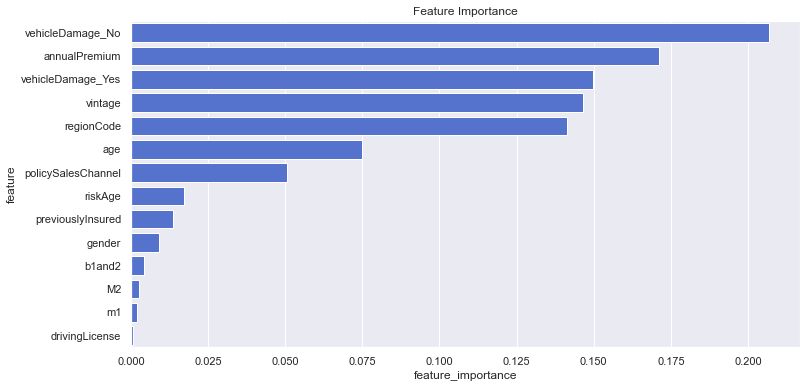

In [301]:
rf = RandomForestRegressor()
# fit the model
rf.fit(x_train, y_train)
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                        'feature_importance': importance})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [302]:
cols_selected_importance = feat_imp['feature'].to_list()
cols_selected_importance

['vehicleDamage_No',
 'annualPremium',
 'vehicleDamage_Yes',
 'vintage',
 'regionCode',
 'age',
 'policySalesChannel',
 'riskAge',
 'previouslyInsured',
 'gender',
 'gender',
 'b1and2',
 'M2',
 'm1',
 'drivingLicense']

## 6.2. Boruta

In [303]:
#definindo dataset de treino e teste para o Boruta
x_train_b = x_train.values
y_train_b = y_train.values.ravel()
rf=RandomForestClassifier( n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=0,random_state=seed).fit(x_train_b,y_train_b)

In [304]:
#comentado para não fazer o algoritimo do boruta#
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
cols_selected_boruta

['previouslyInsured',
 'annualPremium',
 'vintage',
 'age',
 'regionCode',
 'policySalesChannel',
 'vehicleDamage_No',
 'vehicleDamage_Yes']

## 6.3. Columns Selected


In EDA step, I identified 6 features (vehicle Damage, previously insured, vehicle age, driving license,risk Age, age and Gender), in this step only 3(vehicle Damage, previously insured and Age), showed more relevant to the model.

In [39]:
cols_selected=['previouslyInsured',
 'annualPremium',
 'vintage',
 'age',
 'regionCode',
 'policySalesChannel',
 'vehicleDamage_No',
 'vehicleDamage_Yes']

In [40]:
x_train=x_train[cols_selected]

## 6.1 Preparing Validation Dataset

In [41]:
x_val_bkp=x_val.copy()

In [42]:
# Aplicando transformações no x_test separado no passo Feature Engieneering
idsVal=x_val['id']
## Feature Engieneering
x_val=feature_Engieneering(x_val)

## Data Preparation
x_val=dp_numericals(x_val)

x_val['regionCode']=x_val['regionCode'].map(fe_regionCode)
x_val['policySalesChannel']=x_val['policySalesChannel'].map(fe_policySalesChannel)
x_val['drivingLicense']=x_val['drivingLicense'].map(fe_drivingLicense)
x_val['riskAge']=x_val['riskAge'].map(fe_riskAge)
x_val['previouslyInsured']=x_val['previouslyInsured'].map(fe_previouslyInsured)

x_val=ohe.transform(x_val)
x_val=x_val.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})



## Feature Selection
x_val=x_val[cols_selected]
x_val=x_val.fillna(0)

# 7.0. Machine Learning

In [43]:
models_performance=pd.DataFrame()

## 7.1. Comparing Models

In [44]:
models_list=[
                xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytree=0.9),
                LogisticRegression(penalty='l2', solver='newton-cg'),
                GaussianNB(),
                RandomForestClassifier(n_estimators=100,random_state=seed),
                KNeighborsClassifier(n_jobs=-1),
                LGBMClassifier()
            ]

models_performance=models_performance.append(models_train(models_list,x_train,y_train,x_val,y_val,'predict_proba','binaryClass',0))
models_performance

XGBClassifier
LogisticRegression
GaussianNB
RandomForestClassifier
KNeighborsClassifier
LGBMClassifier


Index                   Model ROC AUC Top K Score
0      0           XGBClassifier  0.8619      0.8780
0      0      LogisticRegression  0.8158      0.8780
0      0              GaussianNB  0.8264      0.6389
0      0  RandomForestClassifier  0.9576      0.9396
0      0    KNeighborsClassifier  0.8564      0.8814
0      0          LGBMClassifier  0.8618      0.8780

## 7.2. XGBoost

In [47]:
model_xgb =  models_list[0].fit(x_train,y_train)
yhat_proba_xgb=model_xgb.predict_proba(x_val)

## 7.3. Logistic Regression

In [48]:
model_rLog = models_list[1].fit(x_train,y_train)
yhat_proba_rLog = model_rLog.predict_proba(x_val)

## 7.4. Naive Bayes

In [49]:
model_naiveBayes =models_list[2].fit(x_train,y_train)
yhat_proba_naiveBayes=model_naiveBayes.predict_proba(x_val)

## 7.5. Random Forest

In [51]:
model_rf = models_list[3].fit(x_train,y_train)
yhat_proba_rf= model_rf.predict_proba(x_val)

## 7.6. KNN

In [52]:
model_knn = models_list[4].fit(x_train,y_train)
yhat_proba_knn = model_knn.predict_proba(x_val)

## 7.7. LGBM

In [53]:
model_lgbm = models_list[5].fit(x_train,y_train)
yhat_proba_lgbm = model_lgbm.predict_proba(x_val)

## 7.7. Models Performance

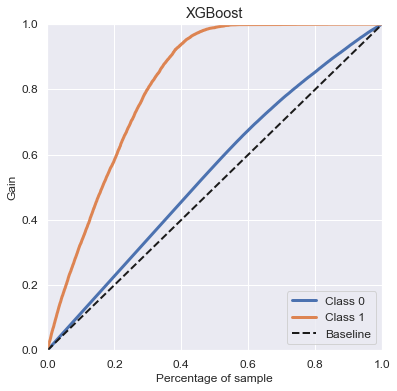

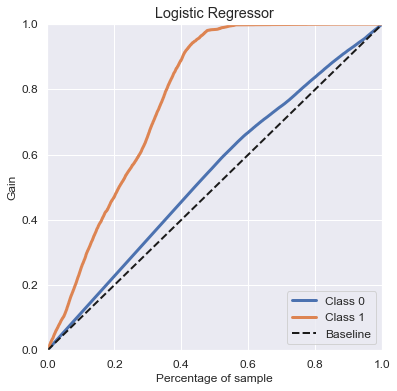

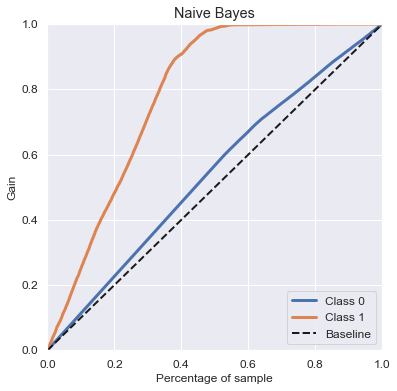

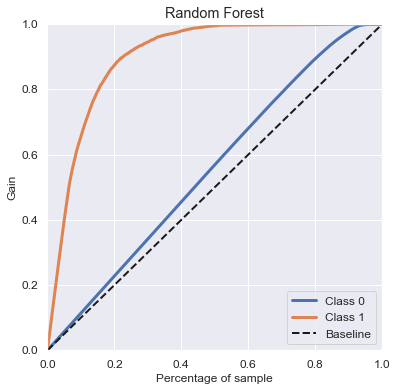

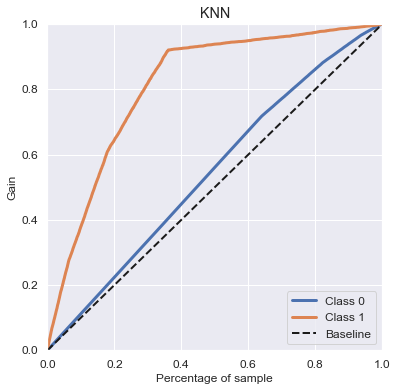

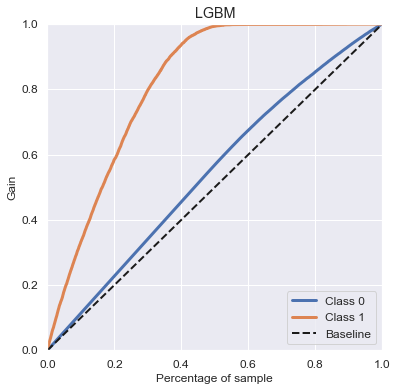

In [54]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb,figsize =(6,6),title='XGBoost');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rLog,figsize =(6,6),title='Logistic Regressor');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_naiveBayes,figsize =(6,6),title='Naive Bayes');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rf,figsize =(6,6),title='Random Forest');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn,figsize =(6,6),title='KNN');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm,figsize =(6,6),title='LGBM');

# 8.0. Crossvalidation

## 8.1. XGBoost

In [55]:
models_performance=models_performance.append(cross_validation(5,'XGBoost',model_xgb,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.2. Logistic Regression

In [56]:
models_performance=models_performance.append(cross_validation(5,'Logistic Regression',model_rLog,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.3. Naive Bayes

In [57]:
models_performance=models_performance.append(cross_validation(5,'GaussianNB',model_naiveBayes,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.4. Random Forest

In [58]:
models_performance=models_performance.append(cross_validation(5,'Random Forest',model_rf,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.5. KNN

In [59]:
models_performance=models_performance.append(cross_validation(5,'KNN',model_knn,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.6. LGBM

In [60]:
models_performance=models_performance.append(cross_validation(5,'LGBM',model_lgbm,x_train,y_train,binary_class_metrics))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.7. Crossvalidation Performance

In [61]:
models_performance.sort_values('Model')

Index                      Model ROC AUC Top K Score
0      0                 GaussianNB  0.8264      0.6389
0      0           GaussianNB - 1/5  0.7847      0.6390
0      0           GaussianNB - 2/5  0.7832      0.6364
0      0           GaussianNB - 3/5  0.7825      0.6357
0      0           GaussianNB - 4/5  0.7863      0.6402
0      0           GaussianNB - 5/5  0.7833      0.6380
0      0                  KNN - 1/5  0.5559      0.8526
0      0                  KNN - 2/5  0.5598      0.8548
0      0                  KNN - 3/5  0.5582      0.8541
0      0                  KNN - 4/5  0.5593      0.8544
0      0                  KNN - 5/5  0.5568      0.8553
0      0       KNeighborsClassifier  0.8564      0.8814
0      0                 LGBM - 1/5  0.5001      0.8770
0      0                 LGBM - 2/5  0.5000      0.8772
0      0                 LGBM - 3/5  0.5000      0.8774
0      0                 LGBM - 4/5  0.5002      0.8773
0      0                 LGBM - 5/5  0.5008      0.8772
0      0             LGBMClassifier  0.8618      0.8780
0      0  Logistic Regression - 1/5  0.5000      0.8774
0      0  Logistic Regression - 2/5  0.5000      0.8774
0      0  Logistic Regression - 3/5  0.5000      0.8774
0      0  Logistic Regression - 4/5  0.5000      0.8774
0      0  Logistic Regression - 5/5  0.5000      0.8775
0      0         LogisticRegression  0.8158      0.8780
0      0        Random Forest - 1/5  0.5416      0.8661
0      0        Random Forest - 2/5  0.5396      0.8651
0      0        Random Forest - 3/5  0.5398      0.8652
0      0        Random Forest - 4/5  0.5469      0.8672
0      0        Random Forest - 5/5  0.5379      0.8647
0      0     RandomForestClassifier  0.9576      0.9396
0      0              XGBClassifier  0.8619      0.8780
0      0              XGBoost - 1/5  0.5000      0.8774
0      0              XGBoost - 2/5  0.5000      0.8774
0      0              XGBoost - 3/5  0.5000      0.8774
0      0              XGBoost - 4/5  0.5002      0.8775
0      0              XGBoost - 5/5  0.5001      0.8775

# 9.0. Hyper Parameters

In [62]:
max_eval=5

In [63]:
hp_result=pd.DataFrame()

## 9.1. LGBM

In [212]:
lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'min_child_weight':(14, 20,30),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [213]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in lgbm_parameter.items()}
    print(hp)
    model_lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree']).fit(x_train,y_train)

    yhat_lgbm=model_lgbm.predict_proba(x_val)
    lgbm_result_hp=binary_class_metrics('LGBM -'+str(i),y_val,yhat_lgbm[:,1],0)
    hp_result=pd.concat([hp_result,lgbm_result_hp])
hp_result

{'num_leaves': 15, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 14, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 45, 'max_depth': 10, 'min_split_gain': 0.01, 'min_child_weight': 20, 'subsample': 1, 'colsample_bytree': 1}


Index    Model ROC AUC Top K Score
0      0  LGBM -0  0.8412      0.8780
0      0  LGBM -1  0.8395      0.8780
0      0  LGBM -2  0.8398      0.8780
0      0  LGBM -3  0.8388      0.8778
0      0  LGBM -4  0.8384      0.8779

## 9.2. XGBoost

In [217]:
xgb_param = {'n_estimators': [80,100,150,200,500,1500,2500,3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9]}

In [219]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in xgb_param.items()}
    print(hp)
    model_xgb = xgb.XGBClassifier(objective='reg:squarederror',#funçao objetiva
                                 n_estimators=hp['n_estimators'],#
                                 eta=hp['eta'],#quantas vezes ele passa pra aprender
                                 max_depth=hp['max_depth'],#maxima de ramificacao
                                 subsample=hp['subsample'],#percentual de feature para amostragem
                                 colsample_bytree=hp['colsample_bytree']).fit(x_train,y_train)

    yhat_xgb=model_xgb.predict_proba(x_val)
    xgb_result_hp=binary_class_metrics('XGBoost'+str(i),y_val,yhat_xgb[:,1],0)
    hp_result=pd.concat([hp_result,xgb_result_hp])
hp_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3}
{'n_estimators': 100, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3}


Index     Model ROC AUC Top K Score
0      0   LGBM -0  0.8412      0.8780
0      0   LGBM -1  0.8395      0.8780
0      0   LGBM -2  0.8398      0.8780
0      0   LGBM -3  0.8388      0.8778
0      0   LGBM -4  0.8384      0.8779
0      0  XGBoost0  0.8351      0.2409
0      0  XGBoost1  0.8417      0.8780
0      0  XGBoost2  0.8365      0.2642
0      0  XGBoost3  0.8434      0.2185
0      0  XGBoost4  0.8318      0.2379

## 9.3. Random Forest

In [233]:
rf_param = {
            'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100,200, 800, 1600,3200],
            'n_jobs':[-1],
            'random_state':[seed]
            }

In [235]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in rf_param.items()}
    print(hp)
    model_rf = RandomForestClassifier(bootstrap= hp['bootstrap'],
                                    max_depth= hp['max_depth'],
                                    max_features= hp['max_features'],
                                    min_samples_leaf= hp['min_samples_leaf'],
                                    min_samples_split= hp['min_samples_split'],
                                    n_estimators= hp['n_estimators'],
                                    n_jobs= hp['n_jobs'],
                                    random_state=hp['random_state']).fit(x_train,y_train)

    yhat_rf=model_rf.predict_proba(x_val)
    rf_result_hp=binary_class_metrics('Random Forest random state - ' + str(i),y_val,yhat_rf[:,1],0)
    hp_result=pd.concat([hp_result,rf_result_hp])
hp_result

{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 77}
{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 800, 'n_jobs': -1, 'random_state': 77}
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 77}
{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 77}
{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 77}


Index                           Model ROC AUC Top K Score
0      0                         LGBM -0  0.8412      0.8780
0      0                         LGBM -1  0.8395      0.8780
0      0                         LGBM -2  0.8398      0.8780
0      0                         LGBM -3  0.8388      0.8778
0      0                         LGBM -4  0.8384      0.8779
0      0                        XGBoost0  0.8351      0.2409
0      0                        XGBoost1  0.8417      0.8780
0      0                        XGBoost2  0.8365      0.2642
0      0                        XGBoost3  0.8434      0.2185
0      0                        XGBoost4  0.8318      0.2379
0      0               Random Forest - 0  0.8772      0.8911
0      0               Random Forest - 1  0.8750      0.8892
0      0               Random Forest - 2  0.8790      0.8912
0      0               Random Forest - 3  0.8798      0.8901
0      0               Random Forest - 4  0.8714      0.8852
0      0  Random Forest random state - 0  0.8774      0.8915
0      0  Random Forest random state - 1  0.8699      0.8837
0      0  Random Forest random state - 2  0.8748      0.8899
0      0  Random Forest random state - 3  0.8702      0.8849
0      0  Random Forest random state - 4  0.8487      0.8780

## 9.4. Hyper Parameters Performances

In [236]:
hp_result.sort_values('Top K Score',ascending=False)

Index                           Model ROC AUC Top K Score
0      0  Random Forest random state - 0  0.8774      0.8915
0      0               Random Forest - 2  0.8790      0.8912
0      0               Random Forest - 0  0.8772      0.8911
0      0               Random Forest - 3  0.8798      0.8901
0      0  Random Forest random state - 2  0.8748      0.8899
0      0               Random Forest - 1  0.8750      0.8892
0      0               Random Forest - 4  0.8714      0.8852
0      0  Random Forest random state - 3  0.8702      0.8849
0      0  Random Forest random state - 1  0.8699      0.8837
0      0                         LGBM -1  0.8395      0.8780
0      0  Random Forest random state - 4  0.8487      0.8780
0      0                        XGBoost1  0.8417      0.8780
0      0                         LGBM -2  0.8398      0.8780
0      0                         LGBM -0  0.8412      0.8780
0      0                         LGBM -4  0.8384      0.8779
0      0                         LGBM -3  0.8388      0.8778
0      0                        XGBoost2  0.8365      0.2642
0      0                        XGBoost0  0.8351      0.2409
0      0                        XGBoost4  0.8318      0.2379
0      0                        XGBoost3  0.8434      0.2185

The best result was **Random Forest** with 89,15% score, but the standart parameters scored **89,16%**, os I'll use the standart parameters

# 10.0. Final Models

In [43]:
rf_bp={'n_estimators': 100, 'n_jobs': -1, 'random_state': seed}
xgb_bp={'objective':'binary:logistic','eval_metric':'error','n_estimators':100,'eta':0.01,'max_depth':10,'subsample':0.7,'colsample_bytree':0.9}
lgbm_bp={'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 1}

In [44]:
model_performance=pd.DataFrame()

### Preparing Test Dataset

In [45]:
x_train=pd.concat([x_train,x_val],axis=0)
y_train=pd.concat([y_train,y_val],axis=0)

### Preparing Test Dataset

In [46]:
# Aplicando transformações no x_test separado no passo Feature Engieneering
idsTest=x_test['id']

## Feature Engieneering
x_test=feature_Engieneering(x_test)

## Data Preparation
x_test=dp_numericals(x_test)

x_test['regionCode']=x_test['regionCode'].map(fe_regionCode)
x_test['policySalesChannel']=x_test['policySalesChannel'].map(fe_policySalesChannel)
x_test['drivingLicense']=x_test['drivingLicense'].map(fe_drivingLicense)
x_test['riskAge']=x_test['riskAge'].map(fe_riskAge)
x_test['previouslyInsured']=x_test['previouslyInsured'].map(fe_previouslyInsured)

x_test=ohe.transform(x_test)
x_test=x_test.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})

## Feature Selection
x_test=x_test[cols_selected]
x_test=x_test.fillna(0)

## 10.1 Random Forest

In [47]:
rf = RandomForestClassifier(
                        n_estimators=rf_bp['n_estimators'],
                        n_jobs=rf_bp['n_jobs'],
                        random_state=rf_bp['random_state']).fit(x_train,y_train)
yhat_proba_rf= rf.predict_proba(x_test)
model_performance=model_performance.append(ranking_class_metrics('Random Forest',y_test,yhat_proba_rf[:,1],0))
model_performance

Index          Model ROC AUC Top K Score
0      0  Random Forest  0.8617      0.8793

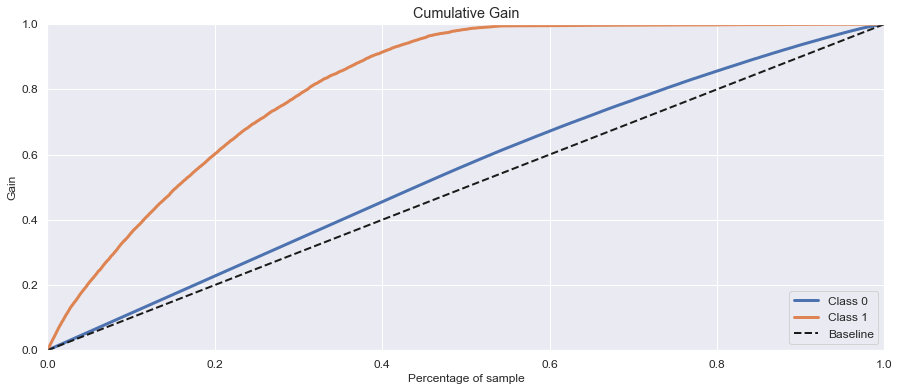

In [48]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_rf,figsize =(15,6),title='Cumulative Gain');

In [49]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [50]:
precision=precision_at_k(df_mp,yhat_proba_rf,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_rf,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.3688422433584782
Recall at K: 0.6019053735816742


## 10.2XGBoost

In [51]:
mxgb=xgb.XGBClassifier(n_estimators=xgb_bp['n_estimators'], 
                      eta=xgb_bp['eta'],
                      max_depth=xgb_bp['max_depth'],
                      subsample=xgb_bp['subsample'],
                      colsample_bytree=xgb_bp['colsample_bytree']).fit(x_train,y_train)
yhat_proba_xgb= mxgb.predict_proba(x_test)
model_performance=model_performance.append(ranking_class_metrics('XGBooster',y_test,yhat_proba_xgb[:,1],0))
model_performance

[12:08:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Index          Model ROC AUC Top K Score
0      0  Random Forest  0.8617      0.8793
0      0      XGBooster  0.8539      0.8774

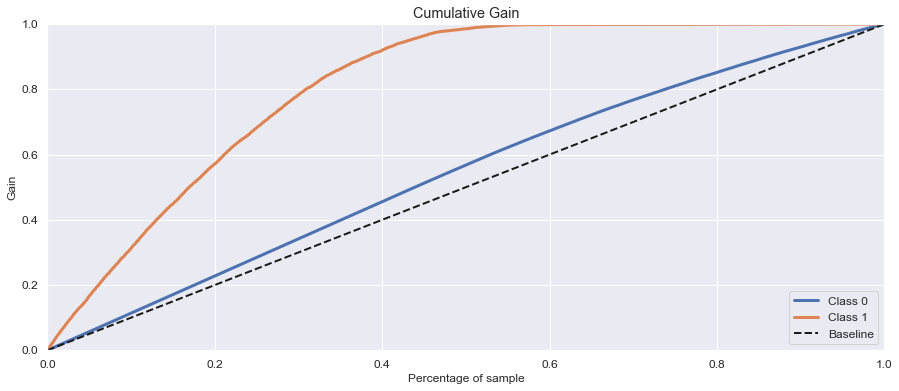

In [52]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_xgb,figsize =(15,6),title='Cumulative Gain');

In [53]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [54]:
precision=precision_at_k(df_mp,yhat_proba_xgb,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_xgb,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.35021318465070517
Recall at K: 0.5715050310426033


## 10.3 LGBM

In [55]:
lgbm=LGBMClassifier(num_leaves=lgbm_bp['num_leaves'],
                    max_depth=lgbm_bp['max_depth'],
                    min_split_gain=lgbm_bp['min_split_gain'],
                    min_chiild_weight=lgbm_bp['min_child_weight'],
                    subsample=lgbm_bp['subsample'],
                    colsample_bytree=lgbm_bp['colsample_bytree']).fit(x_train,y_train)
yhat_proba_lgbm= lgbm.predict_proba(x_test)
model_performance=model_performance.append(ranking_class_metrics('LGBM',y_test,yhat_proba_lgbm[:,1],0))
model_performance

[LightGBM] [Warning] Unknown parameter: min_chiild_weight


Index          Model ROC AUC Top K Score
0      0  Random Forest  0.8617      0.8793
0      0      XGBooster  0.8539      0.8774
0      0           LGBM  0.8551      0.8775

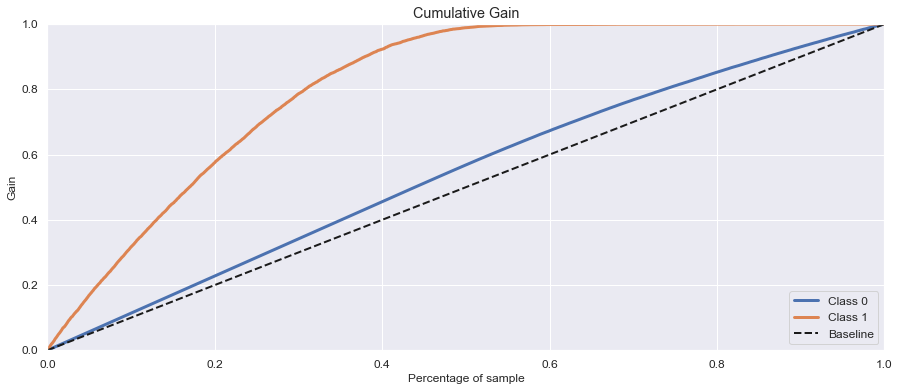

In [56]:
skplt.metrics.plot_cumulative_gain(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

In [57]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

In [58]:
precision=precision_at_k(df_mp,yhat_proba_lgbm,'response',0.2)
recall=recall_at_k(df_mp,yhat_proba_lgbm,'response',0.2)
print('Precision at K: {}'.format(precision))
print('Recall at K: {}'.format(recall))

Precision at K: 0.35277140045916694
Recall at K: 0.5756797259687433


## 10.4 Precision/Recall Comparasion

In [60]:
df_final_performance=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_rf,yhat_proba_xgb,yhat_proba_lgbm]
perc=[0.01,0.05,0.1,0.2,0.3,0.4,0.5]

df_final_performance=topK_performance(df_mp,probas,'response',perc)

In [61]:
df_final_performance[:7]['Model']='Random Forest'
df_final_performance[7:14]['Model']='XBoost'
df_final_performance[14:]['Model']='LGBM'

#### 1% of data

In [62]:
df_final_performance[df_final_performance['perc']==0.01].sort_values(['perc','recall'],ascending=False)

Model        k   perc  perc_target  precision  recall  target_at_k  target_total
0   Random Forest 762.0000 0.0100       0.0507     0.6225  0.0508     474.0000     9342.0000
7          XBoost 762.0000 0.0100       0.0382     0.4679  0.0382     357.0000     9342.0000
14           LGBM 762.0000 0.0100       0.0376     0.4613  0.0377     351.0000     9342.0000

#### 5% of data

In [63]:
df_final_performance[df_final_performance['perc']==0.05].sort_values(['perc','recall'],ascending=False)

Model         k   perc  perc_target  precision  recall  target_at_k  target_total
1   Random Forest 3811.0000 0.0500       0.2084     0.5108  0.2084    1947.0000     9342.0000
15           LGBM 3811.0000 0.0500       0.1691     0.4147  0.1692    1580.0000     9342.0000
8          XBoost 3811.0000 0.0500       0.1663     0.4079  0.1665    1554.0000     9342.0000

#### 10% of data

In [64]:
df_final_performance[df_final_performance['perc']==0.1].sort_values(['perc','recall'],ascending=False)

Model         k   perc  perc_target  precision  recall  target_at_k  target_total
2   Random Forest 7622.0000 0.1000       0.3598     0.4409  0.3598    3361.0000     9342.0000
16           LGBM 7622.0000 0.1000       0.3173     0.3888  0.3173    2964.0000     9342.0000
9          XBoost 7622.0000 0.1000       0.3128     0.3833  0.3128    2922.0000     9342.0000

#### 20% of data

In [65]:
df_final_performance[df_final_performance['perc']==0.2].sort_values(['perc','recall'],ascending=False)

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
3   Random Forest 15244.0000 0.2000       0.6019     0.3688  0.6019    5623.0000     9342.0000
17           LGBM 15244.0000 0.2000       0.5757     0.3528  0.5757    5378.0000     9342.0000
10         XBoost 15244.0000 0.2000       0.5714     0.3502  0.5715    5338.0000     9342.0000

#### 30% of data

In [66]:
df_final_performance[df_final_performance['perc']==0.3].sort_values(['perc','recall'],ascending=False)

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
18           LGBM 22866.0000 0.3000       0.7866     0.3213  0.7866    7348.0000     9342.0000
11         XBoost 22866.0000 0.3000       0.7837     0.3202  0.7838    7321.0000     9342.0000
4   Random Forest 22866.0000 0.3000       0.7828     0.3198  0.7828    7313.0000     9342.0000

#### 40% of data

In [67]:
df_final_performance[df_final_performance['perc']==0.4].sort_values(['perc','recall'],ascending=False)

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
19           LGBM 30488.0000 0.4000       0.9230     0.2828  0.9230    8623.0000     9342.0000
12         XBoost 30488.0000 0.4000       0.9197     0.2818  0.9197    8592.0000     9342.0000
5   Random Forest 30488.0000 0.4000       0.9130     0.2798  0.9131    8529.0000     9342.0000

#### 50% of data

In [68]:
df_final_performance[df_final_performance['perc']==0.5].sort_values(['perc','recall'],ascending=False)

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
20           LGBM 38111.0000 0.5000       0.9891     0.2424  0.9891    9240.0000     9342.0000
13         XBoost 38111.0000 0.5000       0.9855     0.2416  0.9855    9207.0000     9342.0000
6   Random Forest 38111.0000 0.5000       0.9839     0.2412  0.9839    9192.0000     9342.0000

#### Lift Curve

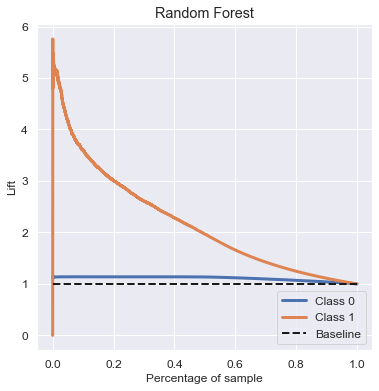

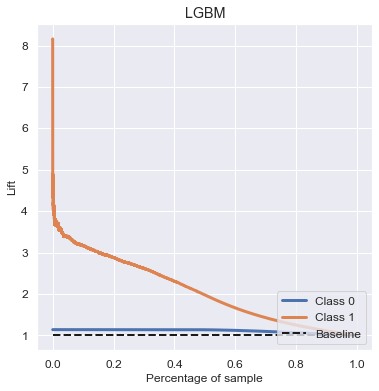

In [69]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_rf,figsize =(6,6),title='Random Forest');
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(6,6),title='LGBM');

## 10.5. Final Model

In [70]:
pickle.dump(rf,open('../model/radomForestModel.pkl','wb'))
pickle.dump(lgbm,open('../model/lgbm.pkl','wb'))
print('Random Forest object size: {0:.2f} KB'.format(os.stat('../model/radomForestModel.pkl').st_size/1024))
print('LGBM object size: {0:.2f} KB'.format(os.stat('../model/lgbm.pkl').st_size/1024))

Random Forest object size: 487798.35 KB
LGBM object size: 332.97 KB


In all scenarios above, Random Forest and LGBM had the best performance, but the Random Forest Model exported is **1521 times** bigger than LGBM model. So, I'll use the **LGBM Model** in production.

In [71]:
threshold=[0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9 ]
threshold_performance=pd.DataFrame()

for i in threshold:
    calc_threshold=lambda x: 0 if x <i else  1
    predicition=list(map(calc_threshold,yhat_proba_rf[:,1]))
    threshold_performance=threshold_performance.append(multi_class_metrics(i,y_test,predicition,0))

In [72]:
threshold_performance

Index  Model  Precision Score  Recall Score  F1 Score  Matthew Correlation Score
0      0 0.1000           0.2826        0.9080    0.4311                     0.3934
0      0 0.2000           0.3310        0.7423    0.4579                     0.3913
0      0 0.2500           0.3588        0.6446    0.4610                     0.3828
0      0 0.3000           0.3839        0.5419    0.4494                     0.3645
0      0 0.3500           0.4125        0.4470    0.4291                     0.3460
0      0 0.4000           0.4417        0.3542    0.3932                     0.3213
0      0 0.5000           0.5132        0.2037    0.2916                     0.2694
0      0 0.6000           0.5994        0.1059    0.1799                     0.2163
0      0 0.7000           0.6313        0.0376    0.0709                     0.1330
0      0 0.8000           0.6129        0.0061    0.0121                     0.0523
0      0 0.9000           0.1667        0.0001    0.0002                     0.0012

I'll use the thershold 0.35

## 10.6. Busisness Performance

In the beginning of this job, the CEO of Insurance All made some questions about model's performance, now I'll respond all of them.

### 1 - Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

Customer between 30-50 have more interesting in vehicle Insurance.

Customer with newest cars, have more interesting in vehicle Insurance.

Customer in in some espefics region have more interesting in vehicle Insurance.

The Attributes more relevantes to define customer interesting are (previouslyInsured,annualPremium,vintage,age,regionCode,policySalesChannel,vehicleDamage

### 2 - Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
Made 20.000 calls using the model to ranking the customers, the sale team will call to 46,98% of all interested, about 3 more times that random method.

In [98]:
calls=20000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))

Insurance All total leads: 127037
Insurance All % of calls: 15.74%


In [109]:
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
0  Model 11999.0000 0.1574       0.4698     0.3658  0.4698    4389.0000     9342.0000

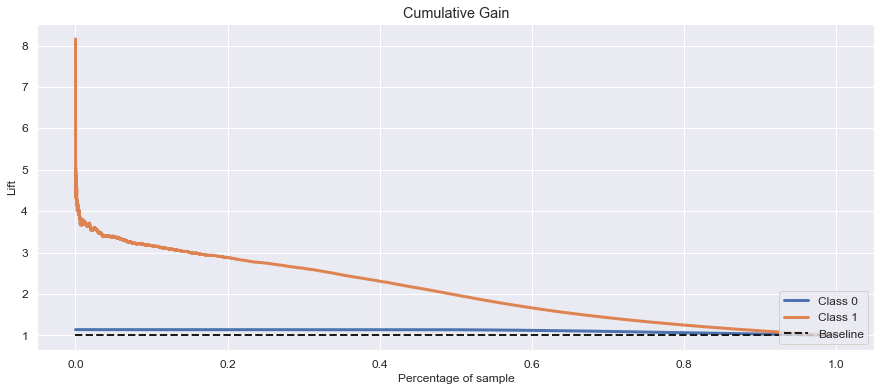

In [113]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

### 3 - E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
Made 40.000 calls using the model to ranking the customers, the sale team will call to 81,20% of all interested, about 2.57 more times that random method.

In [114]:
calls=40000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))

Insurance All total leads: 127037
Insurance All % of calls: 31.49%


In [115]:
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting

Model          k   perc  perc_target  precision  recall  target_at_k  target_total
0  Model 23999.0000 0.3149       0.8120     0.3161  0.8120    7586.0000     9342.0000

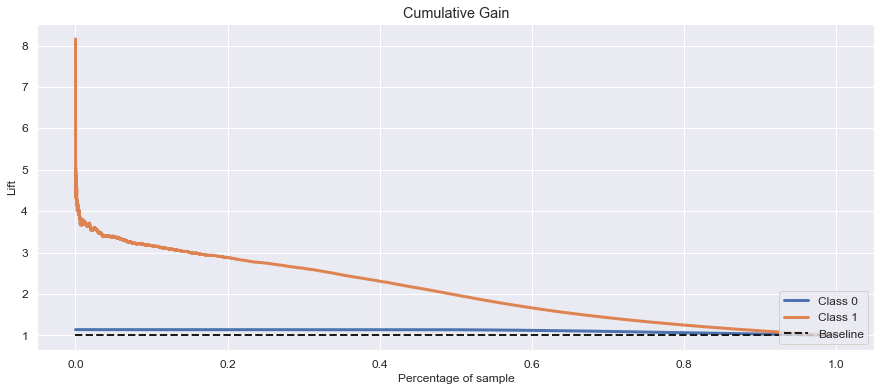

In [116]:
skplt.metrics.plot_lift_curve(y_test, yhat_proba_lgbm,figsize =(15,6),title='Cumulative Gain');

### 4 - Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

Should be necessary 39130 calls to call to 80% of interesting.

In [197]:
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test

k=int(len(df_mp))
df_mp['score']=yhat_proba_lgbm[:,1].tolist()
df_mp=df_mp.sort_values('score',ascending=False)
df_mp=df_mp.reset_index(drop=True)
df_mp['ranking']=df_mp.index+1
df_mp['precision_at_k']=df_mp['response'].cumsum()/df_mp['ranking']
df_mp['recall_at_k']=df_mp['response'].cumsum()/df_mp['response'].sum()

In [199]:
df_mp[df_mp['ranking']==23478]

previouslyInsured  annualPremium  vintage    age  regionCode  policySalesChannel  vehicleDamage_No  vehicleDamage_Yes     id  response  score  ranking  precision_at_k  recall_at_k
23477             0.5418         0.4167   0.0519 0.5538      0.0123              0.1944                 0                  1  25773         1 0.2128    23478          0.3183       0.8000

In [200]:
percCalls=23478/len(df_mp)
qtdCalls=int(np.floor(len(df_test)*percCalls))
print('Should be necessary {} calls to call to 80% of interesting.'.format(qtdCalls))

Should be necessary 39130 calls to call to 80% of interesting.


### Model Result
**20,000 calls(15.74%)**

Suposing that each vehicle Insurance was sell at 2000, the mode bring 298% percent of result totalizing $5,836,494.77.

**40,000 calls(31.49%)**

Suposing that each vehicle Insurance was sell at 2000, the mode bring 257.9% percent of result totalizing $9,288,989.54

In [227]:
calls=20000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting['R$ model']=customerInteresting['target_at_k']*2000
customerInteresting['target_random']=customerInteresting['perc']*customerInteresting['target_total']
customerInteresting['R$ random']=customerInteresting['target_random']*2000
customerInteresting['R$ Final']=customerInteresting['R$ model']-customerInteresting['R$ random']
customerInteresting['% Final']=customerInteresting['R$ model']/customerInteresting['R$ random']
customerInteresting

Insurance All total leads: 127037
Insurance All % of calls: 15.74%


Model          k   perc  perc_target  precision  recall  target_at_k  target_total     R$ model  target_random    R$ random     R$ Final  % Final
0  Model 11999.0000 0.1574       0.4698     0.3658  0.4698    4389.0000     9342.0000 8778000.0000      1470.7526 2941505.2308 5836494.7692   2.9842

In [228]:
calls=40000
totalLeads=df_test.shape[0]
percCalls=calls/totalLeads
print('Insurance All total leads: {}'.format(totalLeads))
print('Insurance All % of calls: {0:.2f}%'.format(percCalls*100))
customerInteresting=pd.DataFrame()
df_mp = x_test.copy()
df_mp['id']=idsTest
df_mp['response']=y_test
probas=[yhat_proba_lgbm]
customerInteresting=topK_performance(df_mp,probas,'response',[percCalls])
customerInteresting['R$ model']=customerInteresting['target_at_k']*2000
customerInteresting['target_random']=customerInteresting['perc']*customerInteresting['target_total']
customerInteresting['R$ random']=customerInteresting['target_random']*2000
customerInteresting['R$ Final']=customerInteresting['R$ model']-customerInteresting['R$ random']
customerInteresting['% Final']=customerInteresting['R$ model']/customerInteresting['R$ random']
customerInteresting

Insurance All total leads: 127037
Insurance All % of calls: 31.49%


Model          k   perc  perc_target  precision  recall  target_at_k  target_total      R$ model  target_random    R$ random     R$ Final  % Final
0  Model 23999.0000 0.3149       0.8120     0.3161  0.8120    7586.0000     9342.0000 15172000.0000      2941.5052 5883010.4615 9288989.5385   2.5790

# 11.0. Model Production Deploy

In [7]:
pickle.dump(lgbm,open('../model/lgbm.pkl','wb'))
pickle.dump(rs,open('../parameters/robustScaller.pkl','wb'))
pickle.dump(ohe,open('../parameters/oneHotEncoder.pkl','wb'))
pickle.dump(mms,open('../parameters/minMaxScaller.pkl','wb'))
pickle.dump(fe_regionCode,open('../parameters/fe_regionCode.pkl','wb'))
pickle.dump(fe_policySalesChannel,open('../parameters/fe_policySalesChannel.pkl','wb'))
pickle.dump(fe_drivingLicense,open('../parameters/fe_drivingLicense.pkl','wb'))
pickle.dump(fe_riskAge,open('../parameters/fe_riskAge.pkl','wb'))
pickle.dump(fe_previouslyInsured,open('../parameters/fe_previouslyInsured.pkl','wb'))
pickle.dump(cols_selected,open('../parameters/cols_selected.pkl','wb'))

NameError: name 'lgbm' is not defined

## 10.6. Busisness Performance

In the beginning of this job, the CEO of Insurance All made some questions about model's performance, now I'll respond all of them.

## 11.1. Insurance All Class

In [8]:
import json
import pickle
import pandas as pd
import numpy as np

from sklearn.ensemble     import RandomForestClassifier
from sklearn              import preprocessing   as pp
from lightgbm             import LGBMClassifier
from sklearn              import metrics         as m
from category_encoders    import OneHotEncoder

class InsuranceAll (object):
    
    
    def __init__(self):
        self.rs=pickle.load(open ('../parameters/robustScaller.pkl','rb'))
        self.mms=pickle.load(open('../parameters/minMaxScaller.pkl','rb'))
        self.ohe=pickle.load(open('../parameters/oneHotEncoder.pkl','rb'))
        self.fe_regionCode=pickle.load(open('../parameters/fe_regionCode.pkl','rb'))
        self.fe_policySalesChannel=pickle.load(open('../parameters/fe_policySalesChannel.pkl','rb'))
        self.fe_drivingLicense=pickle.load(open('../parameters/fe_drivingLicense.pkl','rb'))
        self.fe_riskAge=pickle.load(open('../parameters/fe_riskAge.pkl','rb'))
        self.fe_previouslyInsured=pickle.load(open('../parameters/fe_previouslyInsured.pkl','rb'))
        self.cols_selected=pickle.load(open('../parameters/cols_selected.pkl','rb'))
    
    def dp_numericals(self,df):
        df['annualPremium']=self.rs.fit_transform(df[['annualPremium']])
        df['vintage']=self.mms.fit_transform(df[['vintage']])
        df['age']=self.mms.fit_transform(df[['age']])
        df['vintage']=self.mms.fit_transform(df[['vintage']])
        return df
        
    def data_cleanning(self,df):
        df.columns=['id','gender','age','drivingLicense','regionCode','previouslyInsured','vehicleAge','vehicleDamage','annualPremium','policySalesChannel','vintage']
        return df
                      
    def feature_engieneering(self,df):
        df['riskAge']=df['age'].apply(lambda x: 0 if x>25 else 1)
        return df
    
    def data_preparation(self,df):
        categorical_columns=df.select_dtypes(exclude=['int64','float64']).columns.tolist()
        df=self.dp_numericals(df)
        df=self.feature_engieneering(df)
        df['regionCode']=df['regionCode'].map(self.fe_regionCode)
        df['policySalesChannel']=df['policySalesChannel'].map(self.fe_policySalesChannel)
        df['drivingLicense']=df['drivingLicense'].map(self.fe_drivingLicense)
        df['riskAge']=df['riskAge'].map(self.fe_riskAge)
        df['previouslyInsured']=df['previouslyInsured'].map(self.fe_previouslyInsured)
        df=self.ohe.transform(df)
        df=df.rename(columns={'vehicleAge_1-2 Year':'b1and2','vehicleAge_< 1 Year':'m1','vehicleAge_> 2 Years':'M2'})
        df=df[self.cols_selected]
        df=df.fillna(0)
        return df

    def get_prediction(self,model,original_data,test_data):
        self.calc_threshold=lambda x: 0 if x < 0.35 else 1
        pred = model.predict_proba(test_data)
        original_data['prediction'] = pred[:,1]
        original_data=original_data.sort_values('prediction',ascending=False)
        original_data['prediction']= list(map(self.calc_threshold, original_data['prediction']))
        return original_data.to_json(orient='records', date_format='iso')                      

## 11.2. API Handler

In [9]:
import pickle
import pandas as pd
from flask import Flask,request,Response
#from insuranceAll.InsuranceAll import InsuranceAll

model = pickle.load(open('../model/lgbm.pkl','rb'))

app = Flask(__name__)
@app.route('/insuranceAll/predict',methods=['POST'])

def insurance_all_predict():
    test_json= request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):
            test_raw=pd.DataFrame(test_json,index=[0])
        else:
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
               
        pipeline = InsuranceAll()
        df = test_raw.copy()
        df = pipeline.data_cleanning(df)
        df = pipeline.feature_engieneering(df)
        df = pipeline.data_preparation(df)
        df_response = pipeline.get_prediction(model,test_raw,df)
        return df_response
    
    else:
        return Response('{}', status=200,mimetype='application/json')

    
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Feb/2021 16:19:24] "POST /insuranceAll/predict HTTP/1.1" 200 -
